# Homework 8: Predicting Power Loads with LSTM Networks

## Due: Midnight on **Wednesday, October 29th** (with a 2-hour grace period)  
**Worth:** 85 points

In this assignment, you’ll build and analyze recurrent neural-network models to forecast hourly power demand, using the direct method, and comparing it with autoregressive methods.

**Direct (Non-Autoregressive) Time Series Prediction:**

![Screenshot 2025-10-19 at 11.17.16 AM.png](attachment:6c30ce0c-0c19-42ac-8a65-5623e080fad8.png)


**What we'll do in this homework**

Starting from a working LSTM baseline, you’ll experiment with how the **direct** forcasting models performs, and investigate how **lookback**, **forecast horizon**, and **architecture** affect predictive accuracy and generalization.  
You’ll also explore an **autoregressive** variant, where the model rolls forward one hour at a time—an approach that often highlights how small errors can accumulate.

You’ll complete three problems:

* **Problem 1 — Exploring Lookback and Horizon:**  
  Adjust how far back the model looks and how far ahead it predicts, and examine how these design choices influence MAE/RMSE.

* **Problem 2 — Architectural Tweaks:**  
  Modify the LSTM architecture by deepening the network, stacking layers, or adding a bidirectional layer, and evaluate the effect on validation performance.

* **Problem 3 — Autoregressive Forecasting (ChatGPT Discussion):**  
  Work interactively with ChatGPT to design a one-step-at-a-time autoregressive version of your model, and discuss how it compares to your direct multi-output model.



For each problem, you'll report your best validation metrics, display the learning-curve plots, and briefly reflect on what you learned from the experiment.

There are 5 graded problems, worth 17 points each.

## Setup and Data Loading


In [1]:
# ---------- Standard Library ----------
import os
import time
import math
import random
from pathlib import Path
from collections import Counter

# Environment (set BEFORE importing TensorFlow)
os.environ["PYTHONHASHSEED"] = "0"        # Disable hash randomization
os.environ["TF_DETERMINISTIC_OPS"] = "1"  # Deterministic TF ops where possible
os.environ["TF_CUDNN_DETERMINISM"] = "1"  # Deterministic CuDNN (if GPU)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Suppress TF INFO/WARNING logs

# ---------- Third-Party (General) ----------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit, ShuffleSplit
import kagglehub

# ---------- TensorFlow / Keras ----------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, regularizers, initializers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.layers import GlobalMaxPooling1D, SpatialDropout1D, Bidirectional
# Layers (vision)
from tensorflow.keras.layers import (
    Input, Conv2D,Conv1D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D,
    GlobalMaxPooling2D, BatchNormalization, ReLU, Flatten, Dense, Dropout
)

# Preprocessing (vision)
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ---------- (Optional) NLP-related imports ----------
# If not doing NLP, you can safely remove this block.
from tensorflow.keras.layers import (
    Embedding, GlobalAveragePooling1D, LSTM, GRU, SpatialDropout1D, Bidirectional, Lambda
)
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.datasets import imdb  # uncomment only if needed

# ---------- Reproducibility ----------
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)  # covers TF, Python, and NumPy RNGs

# ---------- Convenience ----------
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)

def format_hms(seconds: float) -> str:
    """Format seconds as H:MM:SS."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

# Example:
# start = time.time()
# ... your code ...
# print("Elapsed:", format_hms(time.time() - start))


### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Single global registry (scaled units)
results = {}   # title -> dict with selected-epoch metrics and (optional) diagnostics

def plot_learning_curves_scaled(
    history,
    title="Learning Curves — MAE & RMSE (scaled)",
    verbose=True,
    record_globals=False,   # set True if you also want global minima as diagnostics
):
    """
    Plot MAE/RMSE directly from Keras History (scaled units).
    Select the epoch by min `val_loss` and record all metrics at that epoch.
    """
    H = history.history if hasattr(history, "history") else history
    if not isinstance(H, dict):
        raise ValueError("history must be a Keras History or a dict")

    if "loss" not in H:
        raise ValueError("History must contain 'loss' (MSE).")

    has_val_loss = "val_loss" in H and len(H["val_loss"]) > 0

    loss     = np.asarray(H["loss"], dtype=float)
    val_loss = np.asarray(H["val_loss"], dtype=float) if has_val_loss else None

    mae      = np.asarray(H["mae"], dtype=float)      if "mae"      in H else None
    val_mae  = np.asarray(H["val_mae"], dtype=float)  if "val_mae"  in H else None
    rmse     = np.asarray(H["rmse"], dtype=float)     if "rmse"     in H else np.sqrt(loss)
    val_rmse = np.asarray(H["val_rmse"], dtype=float) if "val_rmse" in H else (np.sqrt(val_loss) if has_val_loss else None)

    epochs = np.arange(1, len(loss) + 1)

    # ----- Select epoch by min val_loss (or last if no validation) -----
    if has_val_loss:
        sel_idx = int(np.argmin(val_loss))
        sel_note = "min val_loss"
    else:
        sel_idx = len(loss) - 1
        sel_note = "last epoch (no validation)"

    # Values at the selected epoch
    sel = {
        "epoch": sel_idx + 1,
        "selected_by": sel_note,
        "loss": float(loss[sel_idx]),
        "val_loss": float(val_loss[sel_idx]) if has_val_loss else np.nan,
        "mae": float(mae[sel_idx]) if mae is not None else np.nan,
        "val_mae": float(val_mae[sel_idx]) if val_mae is not None and has_val_loss else np.nan,
        "rmse": float(rmse[sel_idx]) if rmse is not None else (float(np.sqrt(loss[sel_idx])) if np.isfinite(loss[sel_idx]) else np.nan),
        "val_rmse": (
            float(val_rmse[sel_idx]) if (val_rmse is not None and has_val_loss)
            else (float(np.sqrt(val_loss[sel_idx])) if has_val_loss and np.isfinite(val_loss[sel_idx]) else np.nan)
        ),
    }

    # Optional: global minima diagnostics
    globs = {}
    if record_globals:
        if val_rmse is not None:
            i = int(np.argmin(val_rmse))
            globs.update(min_val_rmse=float(val_rmse[i]), epoch_min_val_rmse=i+1)
        if val_mae is not None:
            j = int(np.argmin(val_mae))
            globs.update(min_val_mae=float(val_mae[j]), epoch_min_val_mae=j+1)

    # ----- Plot (scaled units) -----
    fig, ax = plt.subplots(figsize=(8, 5))
    if rmse is not None:
        ax.plot(epochs, rmse, label="train RMSE (scaled)")
    if val_rmse is not None:
        ax.plot(epochs, val_rmse, label="val RMSE (scaled)")
    if mae is not None:
        ax.plot(epochs, mae, linestyle="--", label="train MAE (scaled)")
    if val_mae is not None:
        ax.plot(epochs, val_mae, linestyle="--", label="val MAE (scaled)")

    # Mark the selected epoch on validation curves
    if has_val_loss and (val_rmse is not None or val_mae is not None):
        if val_rmse is not None:
            ax.scatter(sel["epoch"], sel["val_rmse"], marker="x", s=70,
                       label=f"val RMSE @ {sel_note} = {sel['val_rmse']:.3g} (ep {sel['epoch']})")
        if val_mae is not None:
            ax.scatter(sel["epoch"], sel["val_mae"], marker="o", s=50,
                       label=f"val MAE @ {sel_note} = {sel['val_mae']:.3g} (ep {sel['epoch']})")

    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Error (scaled units)")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # ----- Record (scaled) -----
    final = {
        "selected_epoch": sel["epoch"],
        "selected_by": sel["selected_by"],
        "val_mae_at_min_valloss": sel["val_mae"],
        "val_rmse_at_min_valloss": sel["val_rmse"],
        "train_mae_at_sel": sel["mae"],
        "train_rmse_at_sel": sel["rmse"],
        # keep last-epoch values if you want them too:
        "final_train_rmse": float(rmse[-1])     if rmse is not None else np.nan,
        "final_val_rmse":   float(val_rmse[-1]) if val_rmse is not None else np.nan,
        "final_train_mae":  float(mae[-1])      if mae is not None else np.nan,
        "final_val_mae":    float(val_mae[-1])  if val_mae is not None else np.nan,
        "units":            "scaled",
    }
    final.update(globs)  # add diagnostics if requested

    if verbose:
        print(f"Selected epoch: {final['selected_epoch']} ({final['selected_by']})")
        print(f"Valid @ sel —  MAE: {final['val_mae_at_min_valloss']:.4g} | RMSE: {final['val_rmse_at_min_valloss']:.4g} (scaled)")
        print(f"Train @ sel —  MAE: {final['train_mae_at_sel']:.4g}  | RMSE: {final['train_rmse_at_sel']:.4g} (scaled)")

    results[title] = final


def print_results(sort_by="val_rmse_at_min_valloss"):
    if not results:
        print("No results recorded yet."); return
    ordering = sorted(results.items(), key=lambda kv: kv[1].get(sort_by, np.inf))
    for name, info in ordering:
        print(f"{name:<35}  val_RMSE@min_val_loss={info.get('val_rmse_at_min_valloss', np.nan):.4g} "
              f"| val_MAE@min_val_loss={info.get('val_mae_at_min_valloss', np.nan):.4g} "
              f"| epoch={info.get('selected_epoch')}  (scaled)")


###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Uses "binary_crossentropy" for binary classification task.
- Assumes `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables, or can specify them when calling
    - If you don’t pass X_train, it will look in the global namespace at call time.
    - If you do pass an explicit X_train=..., that value takes priority.
  
>      # uses global X_train, y_train, ...
>      train_and_test(model)
>
>      # uses explicitly passed datasets
>      train_and_test(model, X_train=new_X, y_train=new_y)

In [3]:
import time
import numpy as np
import tensorflow as tf
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from tensorflow.keras.callbacks import EarlyStopping

def train_and_test(
    model,
    X_train=None, y_train=None,
    X_val=None,   y_val=None,
    X_test=None,  y_test=None,
    *,
    epochs=50,
    optimizer="Adam",
    lr_schedule=1e-3,
    clipnorm=1.0,
    loss="mse",                         # keep MSE for training
    metrics=("mae", "rmse"),            # track MAE & RMSE in curves
    validation_split=0.2,
    random_state=42,
    title="Learning Curves (MSE loss; MAE & RMSE tracked)",
    batch_size=64,
    use_early_stopping=True,
    patience=5,
    min_delta=1e-4,
    callbacks=None,
    verbose=0,
    return_history=False,
    plot_scaled_curves=True,            # uses plot_learning_curves_scaled if available
):
    """
    Trains with MSE and tracks MAE/RMSE. Selects the epoch by min `val_loss`,
    and reports *all* metrics at that same epoch to avoid cherry-picking.
    Returns (history, test_results, info) if return_history=True else (test_results, info).
    """

    # ---------- Resolve datasets lazily from globals if not provided ----------
    g = globals()
    X_train = X_train if X_train is not None else g.get("X_train")
    y_train = y_train if y_train is not None else g.get("y_train")
    X_val   = X_val   if X_val   is not None else g.get("X_val")
    y_val   = y_val   if y_val   is not None else g.get("y_val")
    X_test  = X_test  if X_test  is not None else g.get("X_test")
    y_test  = y_test  if y_test  is not None else g.get("y_test")

    # ---------- Basic checks ----------
    if X_train is None or y_train is None:
        raise ValueError("Training data (X_train, y_train) not provided or defined globally.")
    if X_test is None or y_test is None:
        raise ValueError("Test data (X_test, y_test) not provided or defined globally.")

    # ---------- If no explicit val provided, optionally create one from training ----------
    made_internal_val = False
    if X_val is None or y_val is None:
        if validation_split and validation_split > 0.0:
            X_tr = np.asarray(X_train)
            y_tr = np.asarray(y_train)
            test_size = float(validation_split)

            def _is_single_label_classification(y):
                try:
                    y = np.asarray(y)
                    return np.issubdtype(y.dtype, np.integer) and (len(np.unique(y)) < max(20, 0.02*len(y)))
                except Exception:
                    return False

            if _is_single_label_classification(y_tr):
                splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
                (train_idx, val_idx), = splitter.split(X_tr, y_tr)
            else:
                splitter = ShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
                (train_idx, val_idx), = splitter.split(np.arange(len(X_tr)))

            X_train, y_train = X_tr[train_idx], y_tr[train_idx]
            X_val,   y_val   = X_tr[val_idx],   y_tr[val_idx]
            made_internal_val = True
        else:
            if use_early_stopping:
                raise ValueError("Early stopping needs validation. Provide (X_val, y_val) or set validation_split > 0.")

    if title:
        print(f"\n{title}\n")

    # ---------- Optimizer ----------
    if isinstance(optimizer, str):
        opt = getattr(tf.keras.optimizers, optimizer)(learning_rate=lr_schedule, clipnorm=clipnorm)
    else:
        opt = optimizer

    # ---------- Metrics ----------
    keras_metrics = []
    for m in metrics:
        if isinstance(m, str):
            key = m.lower()
            if key in ("mae", "meanabsoluteerror"):
                keras_metrics.append(tf.keras.metrics.MeanAbsoluteError(name="mae"))
            elif key in ("rmse", "rootmeansquarederror"):
                keras_metrics.append(tf.keras.metrics.RootMeanSquaredError(name="rmse"))
            elif key in ("mse", "meansquarederror"):
                keras_metrics.append(tf.keras.metrics.MeanSquaredError(name="mse"))
            else:
                keras_metrics.append(m)
        else:
            keras_metrics.append(m)

    model.compile(optimizer=opt, loss=loss, metrics=keras_metrics)

    # ---------- Callbacks ----------
    cb = [] if callbacks is None else list(callbacks)
    if use_early_stopping:
        cb = [EarlyStopping(monitor="val_loss", patience=patience, min_delta=min_delta,
                            restore_best_weights=True, verbose=verbose)] + cb

    # ---------- Fit ----------
    start = time.time()
    fit_kwargs = dict(
        x=X_train, y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=cb,
        verbose=verbose,
        shuffle=True,
    )
    if X_val is not None and y_val is not None:
        fit_kwargs["validation_data"] = (X_val, y_val)

    history = model.fit(**fit_kwargs)
    hist = history.history

    # ---------- Select epoch by min val_loss ----------
    if "val_loss" in hist and len(hist["val_loss"]) > 0:
        sel_idx = int(np.argmin(hist["val_loss"]))       # 0-based
        selected_by = "val_loss"
    else:
        # fallback: last epoch if no val set
        sel_idx = len(hist.get("loss", [])) - 1
        selected_by = "loss (no validation)"

    # Gather metrics at selected epoch (scaled units)
    def _get(name):
        v = hist.get(name, None)
        return float(v[sel_idx]) if v is not None and len(v) > sel_idx else float("nan")

    selected = {
        "epoch":         sel_idx + 1,
        "selected_by":   selected_by,
        "loss":          _get("loss"),
        "val_loss":      _get("val_loss"),
        "mae":           _get("mae"),
        "val_mae":       _get("val_mae"),
        "rmse":          _get("rmse") if "rmse" in hist else float(np.sqrt(_get("loss"))) if np.isfinite(_get("loss")) else float("nan"),
        "val_rmse":      _get("val_rmse") if "val_rmse" in hist else float(np.sqrt(_get("val_loss"))) if np.isfinite(_get("val_loss")) else float("nan"),
    }

    # ---------- Evaluate on test set (scaled units) ----------
    test_out = model.evaluate(X_test, y_test, verbose=0)
    metric_names = model.metrics_names
    test_results = dict(zip(metric_names, map(float, np.atleast_1d(test_out))))
    if "loss" in test_results:
        test_results["rmse_from_mse_loss"] = float(np.sqrt(test_results["loss"]))

    elapsed = time.time() - start

    # ---------- Console summary (report everything at selected epoch) ----------
    # print(f"Selected epoch: {selected['epoch']} (by {selected['selected_by']})")
    # print(f"Train @ sel —  LOSS: {selected['loss']:.6f} | MAE: {selected['mae']:.6f} | RMSE: {selected['rmse']:.6f}")
    # if np.isfinite(selected["val_loss"]):
    #     print(f"Valid @ sel —  LOSS: {selected['val_loss']:.6f} | MAE: {selected['val_mae']:.6f} | RMSE: {selected['val_rmse']:.6f}")
    # print("Test  (final weights after ES restore) — " +
    #       " | ".join([f"{k.upper()}: {v:.6f}" for k, v in test_results.items()]) +
    #       f"   (time: {elapsed:.1f}s)")

    # ---------- Optional: plot scaled curves & record to registry ----------
    if plot_scaled_curves and 'plot_learning_curves_scaled' in globals():
        plot_learning_curves_scaled(history, title=title, verbose=verbose)

    info = {
        "made_internal_val": made_internal_val,
        "elapsed_sec": elapsed,
        "selected_epoch": selected["epoch"],
        "selected_by": selected_by,
        "train_at_sel": {"loss": selected["loss"], "mae": selected["mae"], "rmse": selected["rmse"]},
        "val_at_sel":   {"loss": selected["val_loss"], "mae": selected["val_mae"], "rmse": selected["val_rmse"]},
    }

    if return_history:
        return history, test_results, info


### Learning Rate Schedulers

In [4]:
# Must be input as callback in train_and_test(....   , callbacks=[reduce_lr] )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

### Load and prepare data

Window kept: 2025-01-01 00:00:00  →  2025-05-31 23:00:00  (3624 hours)
Split sizes — train: 2536, val: 543, test: 545


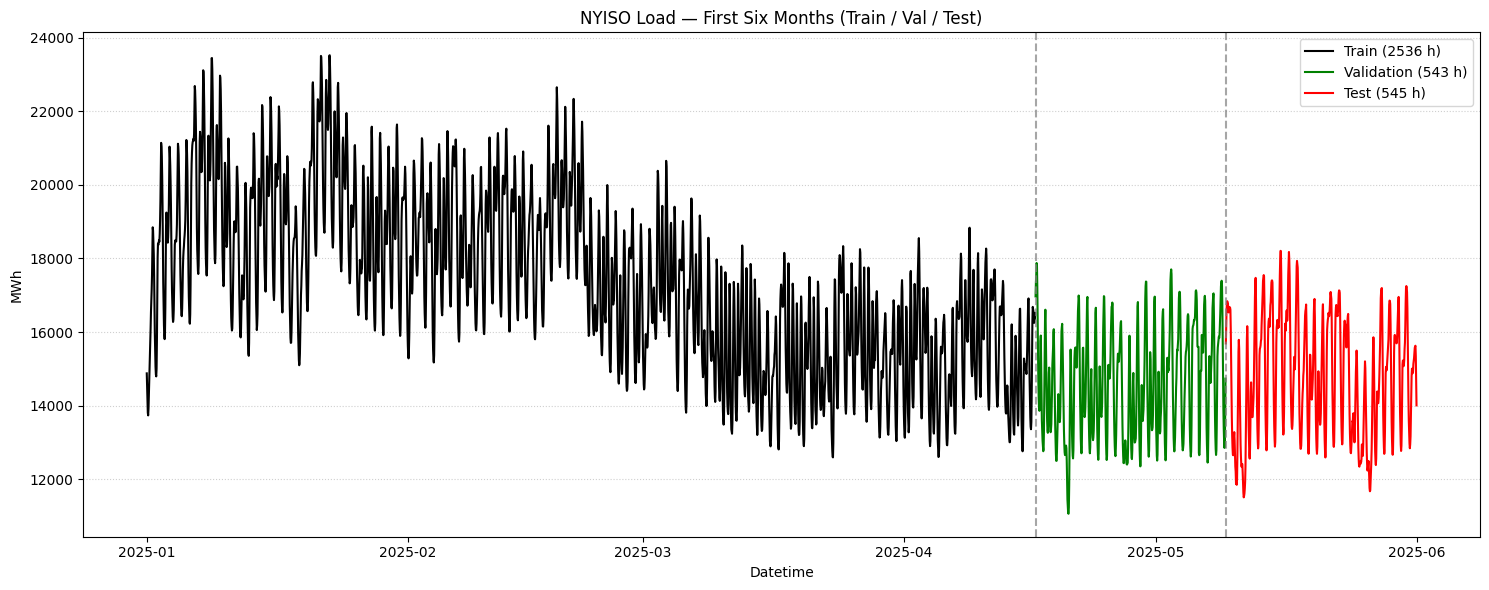


MegaWatts per Hour — First Six Months

Datetime
2025-01-01 00:00:00    14877.0
2025-01-01 01:00:00    14487.0
2025-01-01 02:00:00    14091.0
2025-01-01 03:00:00    13804.0
2025-01-01 04:00:00    13735.0
2025-01-01 05:00:00    13929.0
Freq: h, Name: NYISO_Load, dtype: float64
....
Datetime
2025-05-31 18:00:00    15571.0
2025-05-31 19:00:00    15610.0
2025-05-31 20:00:00    15628.0
2025-05-31 21:00:00    15342.0
2025-05-31 22:00:00    14727.0
2025-05-31 23:00:00    14007.0
Freq: h, Name: NYISO_Load, dtype: float64
Length: 3624 hours


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# --------------------------
# 0) Load & reshape (Hr1..Hr24 only)
# --------------------------
df = pd.read_csv("nyiso_loads.csv")

# strictly keep Hr1..Hr24 (drop Hr25 if present)
hour_cols = sorted(
    [c for c in df.columns if re.fullmatch(r"Hr\d+", c) and 1 <= int(c[2:]) <= 24],
    key=lambda c: int(c[2:])
)

# wide -> long (1 row per hour)
long_df = df.melt(
    id_vars=["Year", "Month", "Day"],
    value_vars=hour_cols,
    var_name="Hour",
    value_name="Load"
).sort_values(["Year", "Month", "Day", "Hour"], ignore_index=True)

# datetime index
long_df["Datetime"] = (
    pd.to_datetime(long_df[["Year", "Month", "Day"]]) +
    pd.to_timedelta(long_df["Hour"].str.extract(r"(\d+)").astype(int)[0] - 1, unit="h")
)
long_df = long_df.sort_values("Datetime", ignore_index=True)

# series
load_series = pd.Series(long_df["Load"].values, index=long_df["Datetime"], name="NYISO_Load")
load_series.index.name = "Datetime"

# --------------------------
# 1) Keep ONLY the first six months from the series start
# --------------------------
start = load_series.index.min().normalize()
end   = start + pd.DateOffset(months=5)   # exclusive upper bound
s6    = load_series.loc[(load_series.index >= start) & (load_series.index < end)].copy()

# Enforce hourly cadence & light gap fill
s6 = s6.asfreq('h')             # pandas now prefers lowercase 'h'
s6 = s6.interpolate(limit=3)    # fill gaps up to 3 hours
s6 = s6.dropna()

print(f"Window kept: {s6.index[0]}  →  {s6.index[-1]}  ({len(s6)} hours)")

# --------------------------
# 2) Chronological split: 70% / 15% / 15%
# --------------------------
N       = len(s6)
n_train = int(0.70 * N)
n_val   = int(0.15 * N)
n_test  = N - n_train - n_val

idx_tr = slice(0, n_train)
idx_va = slice(n_train, n_train + n_val)
idx_te = slice(n_train + n_val, N)

t_train_end = s6.index[n_train]
t_val_end   = s6.index[n_train + n_val]

print(f"Split sizes — train: {n_train}, val: {n_val}, test: {n_test}")

# --------------------------
# 3) Plot Train / Val / Test
# --------------------------
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(s6.index[idx_tr], s6.values[idx_tr], color='black', label=f"Train ({n_train} h)")
ax.plot(s6.index[idx_va], s6.values[idx_va], color='green', label=f"Validation ({n_val} h)")
ax.plot(s6.index[idx_te], s6.values[idx_te], color='red',   label=f"Test ({n_test} h)")

ax.axvline(t_train_end, linestyle='--', color='gray', alpha=0.7)
ax.axvline(t_val_end,   linestyle='--', color='gray', alpha=0.7)

ax.set_title("NYISO Load — First Six Months (Train / Val / Test)")
ax.set_xlabel("Datetime")
ax.set_ylabel("MWh")
ax.grid(True, axis='y', linestyle=':', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()

# --------------------------
# 4) Quick peek & NumPy export
# --------------------------
print("\nMegaWatts per Hour — First Six Months\n")
print(s6.head(6))
print('....')
print(s6.tail(6))
print(f"Length: {len(s6)} hours")

# For RNN/LSTM training
load_array = s6.to_numpy().astype(np.float32)


#### Plot Last Two Weeks

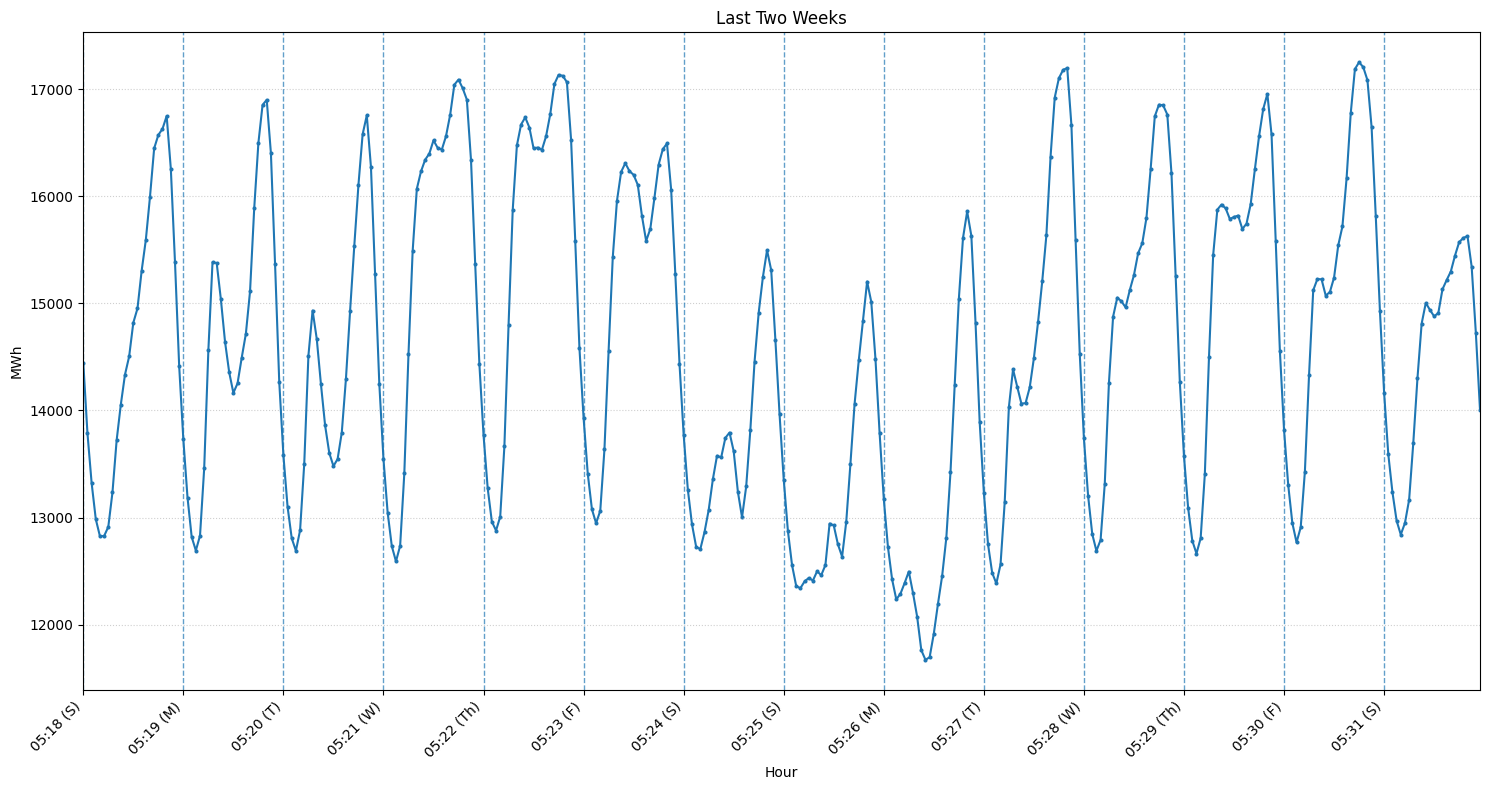

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Choose the series to plot (use s6 if you limited to first six months)
series = s6    # or load_series

period_hours = 24 * 14
sel = series.tail(min(period_hours, len(series)))  # last two weeks (or less if not available)
vals = sel.values

# positions of midnights within the selection
midnight_mask = sel.index.hour == 0
day_positions = np.nonzero(midnight_mask)[0]
day_times = sel.index[midnight_mask]

# weekday letter: Mon=M, Tue=T, Wed=W, Thu=Th, Fri=F, Sat/Sun=S
def wd_letter(ts: pd.Timestamp) -> str:
    dow = ts.dayofweek  # Mon=0 ... Sun=6
    if dow >= 5:
        return "S"
    return ["M", "T", "W", "Th", "F"][dow]

day_labels = [f"{t:%m}:{t:%d} ({wd_letter(t)})" for t in day_times]

fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title("Last Two Weeks")
ax.plot(vals)
ax.scatter(range(len(vals)), vals, marker='.', s=15)

# vertical lines at each midnight
for x in day_positions:
    ax.axvline(x, linestyle='--', linewidth=1, alpha=0.7)

ax.set_xlim(0, len(vals) - 1)
ax.set_xlabel("Hour")
ax.set_ylabel("MWh")
ax.grid(True, axis='y', linestyle=':', alpha=0.6)

ax.set_xticks(day_positions)
ax.set_xticklabels(day_labels, rotation=45, ha="right")

plt.tight_layout()
plt.show()


### Preprocess Data into Sliding Windows


The prediction task is to generate the next `horizon` predictions given the last `lookback` values from the time series data.  

> Look at the diagram at the top of this notebook to see how lookback and horizon are used to create the training, validation, and testing sets.

**Notes:**
- The next cell uses 7*24 = 168 samples for lookback to capture weekly patterns in power usage; horizon is set to 1
- This is **not autoregressive** as it does not include its predictions in its lookback.
- Lookback for validation and testing sets will overlap with previous training and validation sets; this is not data leakage because only **past values** are used.
- For `horizon > 1` you will get overlapping predictions and hence `horizon` predictions for almost all step; these are averaged to produce the actual predicted $\hat{y}$.

In [7]:
# assume s6 exists (your Jan–Jun hourly Series), and you computed n_train, n_val
train = s6.iloc[:n_train]
val   = s6.iloc[n_train:n_train+n_val]
test  = s6.iloc[n_train+n_val:]

# --------------------------
# 3) Scaling (fit on train only)
# --------------------------

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x = scaler.fit_transform(train.values.reshape(-1,1)).astype(np.float32)
val_x   = scaler.transform(val.values.reshape(-1,1)).astype(np.float32)
test_x  = scaler.transform(test.values.reshape(-1,1)).astype(np.float32)

# --------------------------
# 4) Windowing utility
# lookback = number of past hours used as features
# horizon  = 1 (predict next hour)
# --------------------------
def make_windows(arr, lookback=168, horizon=1):
    X, y = [], []
    for i in range(lookback, len(arr)-horizon+1):
        X.append(arr[i-lookback:i, 0])
        y.append(arr[i:i+horizon, 0])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    # shapes: X -> (samples, lookback), y -> (samples, horizon)
    return X[..., None], y  # add feature dim -> (samples, lookback, 1)

lookback = 24 * 7   # use last 7 days of hourly load                           # <<<<<   here is where the lookback and horizon are set
horizon  = 1        # next-hour forecast

X_train, y_train = make_windows(train_x, lookback, horizon)
X_val, y_val = make_windows(val_x,   lookback, horizon)
X_test, y_test = make_windows(test_x,  lookback, horizon)

print("Shapes:")
print("  X_train:", X_train.shape, "y_test:", y_test.shape)
print("  X_val:", X_val.shape, "y_val:", y_val.shape)
print("  X_test:", X_test.shape, "y_test:", y_test.shape)

Shapes:
  X_train: (2368, 168, 1) y_test: (377, 1)
  X_val: (375, 168, 1) y_val: (375, 1)
  X_test: (377, 168, 1) y_test: (377, 1)


### Build a Baseline LSTM Model for lookback = 2 weeks, horizon = next hour


Baseline Model

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.8835 - mae: 0.7592 - rmse: 0.9343 - val_loss: 0.3210 - val_mae: 0.4924 - val_rmse: 0.5666
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3932 - mae: 0.5314 - rmse: 0.6266 - val_loss: 0.2912 - val_mae: 0.4565 - val_rmse: 0.5397
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3031 - mae: 0.4679 - rmse: 0.5502 - val_loss: 0.2134 - val_mae: 0.3837 - val_rmse: 0.4620
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2407 - mae: 0.4114 - rmse: 0.4901 - val_loss: 0.1478 - val_mae: 0.3209 - val_rmse: 0.3844
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1741 - mae: 0.3456 - rmse: 0.4168 - val_loss: 0.1061 - val_mae: 0.2753 - val_rmse: 0.3258
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1203 - mae: 0.2817 - rmse: 0.3468 - val_loss: 0.0700 - val_mae: 0.2287 - val_rmse: 0.2645
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0963 - mae: 0.24

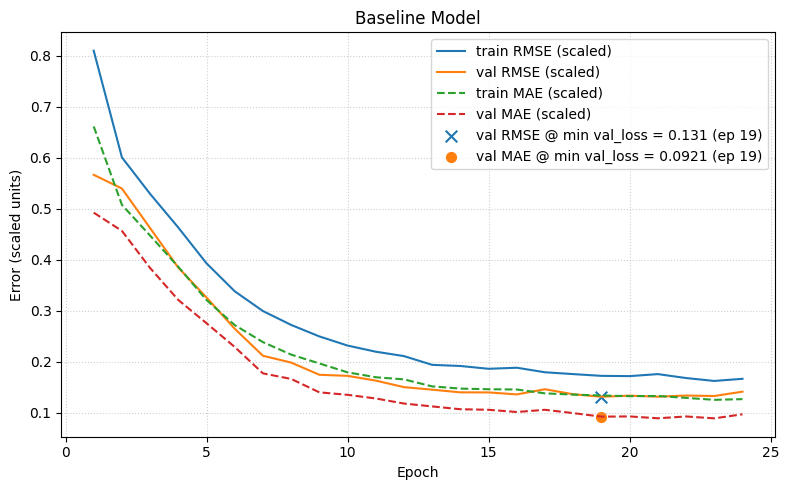

Selected epoch: 19 (min val_loss)
Valid @ sel —  MAE: 0.09209 | RMSE: 0.1311 (scaled)
Train @ sel —  MAE: 0.1335  | RMSE: 0.1721 (scaled)


In [8]:
# Baseline LSTM model

hn = keras.initializers.HeNormal(seed=random_seed)

baseline_model = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=hn),
    Dense(horizon)
])


train_and_test( baseline_model,title="Baseline Model",verbose=1)

### Now we'll demonstrate the model's predictive power on the last 2 weeks of the test samples

Test RMSE (avg over all steps): 0.097 (scaled)
Test  MAE (avg over all steps): 0.081 (scaled)


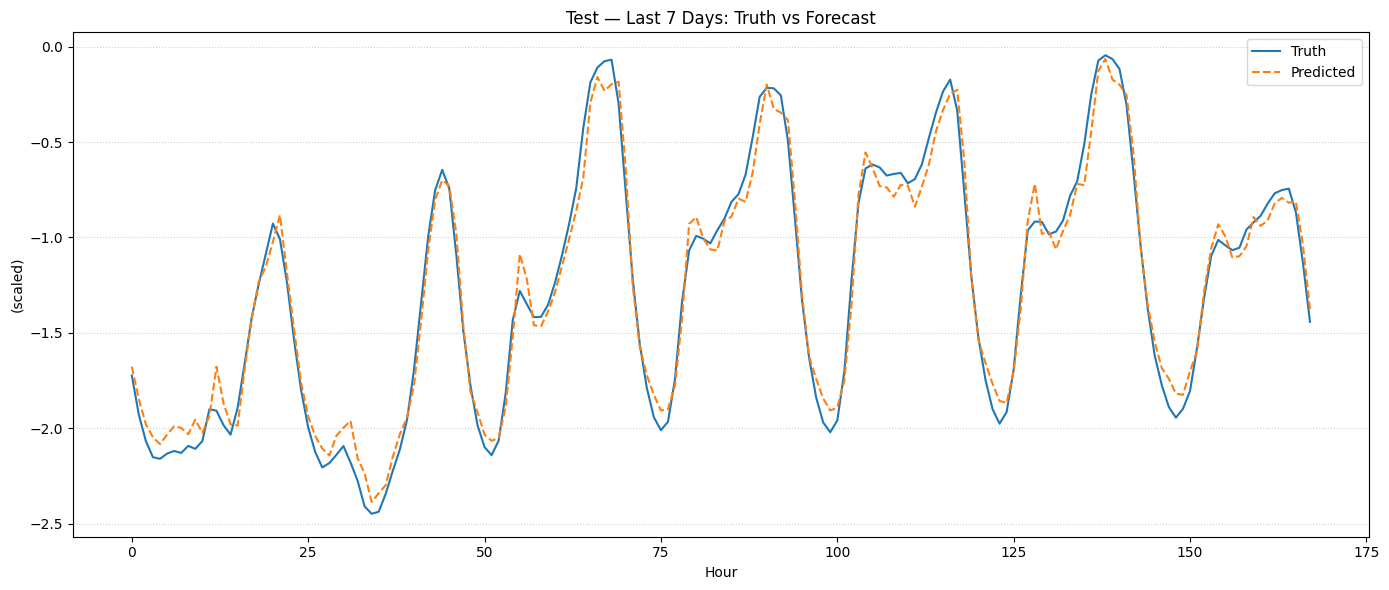

In [9]:
def evaluate_on_test(
    model,
    *,
    target_scaler=None,          # pass your y scaler here if you want original units
    report_in_scaled=True,       # set False to invert to original units
    unit_scaled="(scaled)",
    unit_original="MW",          # or "MWh" if your target is energy, not power
    plot_last_hours=24*7,
):
    """
    Evaluate on X_test/y_test and plot the last `plot_last_hours` predictions.
    Supports horizon=1 and direct multi-output (H>1).
    """
    # 1) Predict
    y_pred = model.predict(X_test, verbose=0)         # (n_windows, H) or (n_windows, 1)
    if y_pred.ndim == 1:
        y_pred = y_pred[:, None]
    H = y_pred.shape[1]

    # 2) Choose units (scaled vs original)
    def maybe_invert(arr):
        if report_in_scaled or target_scaler is None:
            return arr
        a = np.asarray(arr).reshape(-1, 1)
        return target_scaler.inverse_transform(a).ravel()

    # 3) Build comparable arrays for metrics
    # y_test matches y_pred shape: (n_windows, H)
    y_true = y_test
    # Metrics (per-horizon and averaged) in chosen units
    err = maybe_invert(y_pred.ravel()) - maybe_invert(y_true.ravel())
    rmse_avg = float(np.sqrt(np.mean(err**2)))
    mae_avg  = float(np.mean(np.abs(err)))

    if H > 1:
        # per-horizon
        y_true_u = maybe_invert(y_true)
        y_pred_u = maybe_invert(y_pred)
        mae_per_h  = np.mean(np.abs(y_true_u - y_pred_u), axis=0)
        rmse_per_h = np.sqrt(np.mean((y_true_u - y_pred_u)**2, axis=0))

    # 4) Prepare a single timeline for plotting
    def stitch_direct_predictions(yhat):
        """Average overlaps for direct multi-step predictions."""
        n, HH = yhat.shape
        total = n + HH - 1
        out = np.zeros(total, dtype=float)
        cnt = np.zeros(total, dtype=float)
        for i in range(n):
            out[i:i+HH] += yhat[i]
            cnt[i:i+HH] += 1.0
        return out / np.maximum(cnt, 1.0)

    # Choose units for plotting
    unit = unit_scaled if (report_in_scaled or target_scaler is None) else unit_original

    if H == 1:
        y_true_t = maybe_invert(y_true.ravel())
        y_pred_t = maybe_invert(y_pred.ravel())
    else:
        # stitch both for a continuous timeline
        y_pred_t = stitch_direct_predictions(maybe_invert(y_pred))
        y_true_t = stitch_direct_predictions(maybe_invert(y_true))

    # 5) Print summary
    print(f"Test RMSE (avg over all steps): {rmse_avg:,.3f} {unit}")
    print(f"Test  MAE (avg over all steps): {mae_avg:,.3f} {unit}")
    if H > 1:
        print("Per-horizon (0 = 1-step ahead):")
        print("  MAE :", np.round(mae_per_h, 3))
        print("  RMSE:", np.round(rmse_per_h, 3))

    # 6) Plot last N hours
    N = min(plot_last_hours, len(y_true_t))
    plt.figure(figsize=(14, 6))
    plt.title("Test — Last 7 Days: Truth vs Forecast")
    plt.plot(y_true_t[-N:], label="Truth")
    plt.plot(y_pred_t[-N:], label="Predicted", linestyle="--")
    plt.xlabel("Hour")
    plt.ylabel(unit)
    plt.grid(True, axis='y', linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

evaluate_on_test(baseline_model)

## Problem One — Exploring Lookback and Horizon

Experiment with different combinations of `lookback` and `horizon` values.  
For example, you might double the lookback window (e.g., from 1 week to 2 weeks) or extend the prediction horizon to 24 hours.  

After each change:
- Retrain your model.
- Use `evaluate_on_test(...)` to visualize the extended 2-week prediction.
- Compare validation and test MAE/RMSE across experiments.
- Answer the graded questions.

> *Note:* You’ll need to adjust the data-preparation cell above to rebuild the training, validation, and testing sets with the new parameters.


EXPERIMENT 1: Baseline - Lookback=168 (7 days), Horizon=1
EXPERIMENT 2: Lookback=336 (14 days), Horizon=1
Shapes:
  X_train: (2200, 336, 1) y_train: (2200, 1)
  X_val: (207, 336, 1) y_val: (207, 1)
  X_test: (209, 336, 1) y_test: (209, 1)

Exp 2: Lookback=336, Horizon=1

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.6833 - mae: 0.6865 - rmse: 0.8248 - val_loss: 0.3667 - val_mae: 0.5074 - val_rmse: 0.6056
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3702 - mae: 0.5188 - rmse: 0.6082 - val_loss: 0.3210 - val_mae: 0.4636 - val_rmse: 0.5666
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3047 - mae: 0.4728 - rmse: 0.5518 - val_loss: 0.2473 - val_mae: 0.3987 - val_rmse: 0.4973
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2370 - mae: 0.4133 - rmse: 0.4866 - val_loss: 0.1508 - val_mae: 0.3142 - val_rmse: 0.3883
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1664 - mae: 0.3373 - rmse: 0.4077 - val_loss: 0.1117 - val_mae:

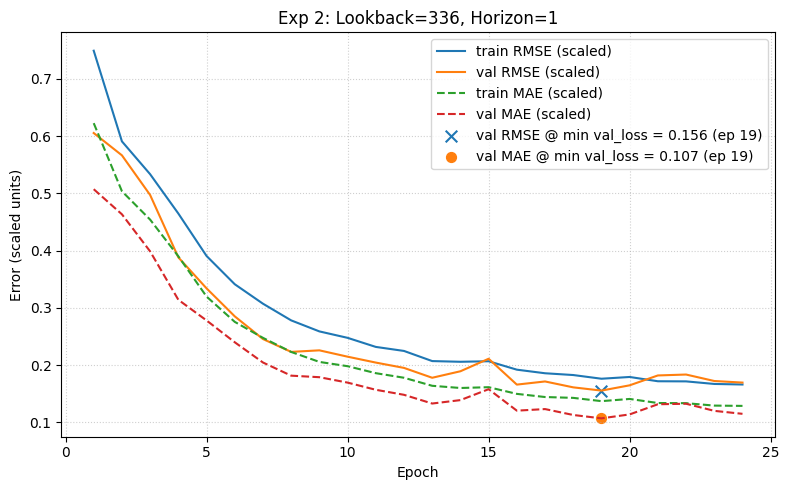

Selected epoch: 19 (min val_loss)
Valid @ sel —  MAE: 0.107 | RMSE: 0.1555 (scaled)
Train @ sel —  MAE: 0.1371  | RMSE: 0.1762 (scaled)
Test RMSE (avg over all steps): 0.132 (scaled)
Test  MAE (avg over all steps): 0.107 (scaled)


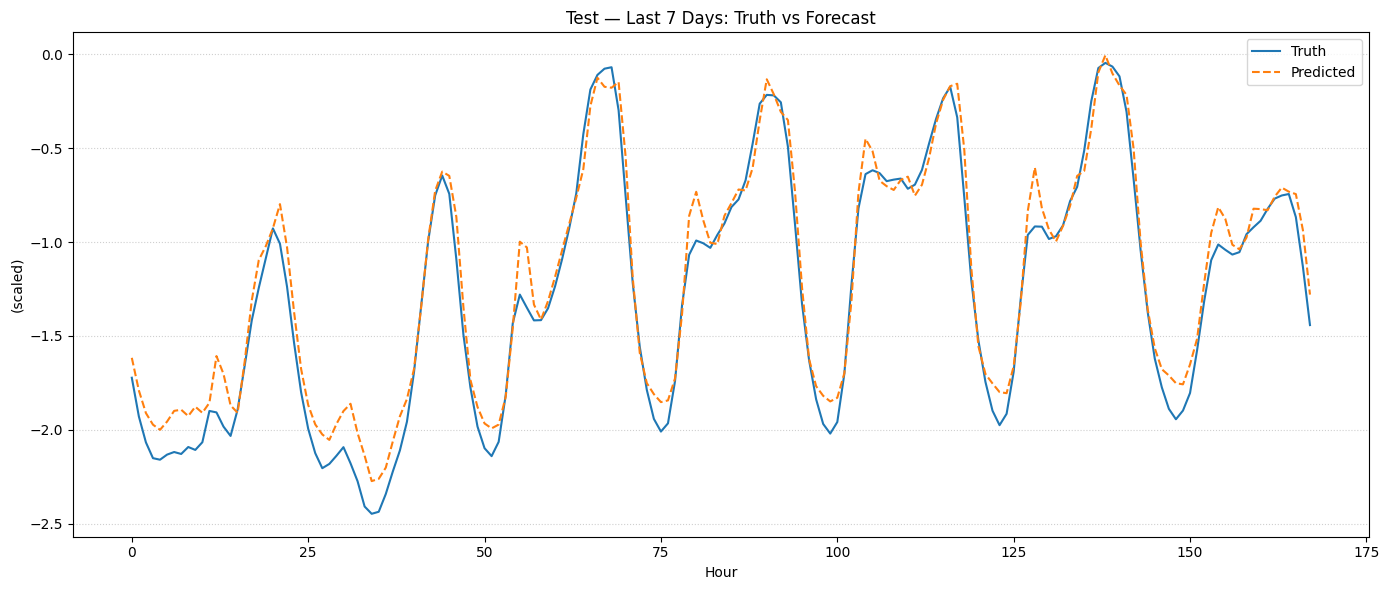

In [11]:
# Your code here, add as many cells as you like
# Problem 1: Exploring Lookback and Horizon

# Store results for comparison
experiment_results = []

# Experiment 1: Baseline (already done) - lookback=168 (7 days), horizon=1
print("EXPERIMENT 1: Baseline - Lookback=168 (7 days), Horizon=1")
# Already trained above, results shown

# Experiment 2: Double the lookback - lookback=336 (14 days), horizon=1
print("EXPERIMENT 2: Lookback=336 (14 days), Horizon=1")

lookback = 24 * 14  # 2 weeks
horizon = 1

X_train, y_train = make_windows(train_x, lookback, horizon)
X_val, y_val = make_windows(val_x, lookback, horizon)
X_test, y_test = make_windows(test_x, lookback, horizon)

print("Shapes:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_val:", X_val.shape, "y_val:", y_val.shape)
print("  X_test:", X_test.shape, "y_test:", y_test.shape)

model_exp2 = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=he),
    Dense(horizon)
])

train_and_test(model_exp2, title="Exp 2: Lookback=336, Horizon=1", verbose=1)
evaluate_on_test(model_exp2)

EXPERIMENT 3: Lookback=84 (3.5 days), Horizon=1
Shapes:
  X_train: (2452, 84, 1) y_train: (2452, 1)
  X_val: (459, 84, 1) y_val: (459, 1)
  X_test: (461, 84, 1) y_test: (461, 1)

Exp 3: Lookback=84, Horizon=1

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6672 - mae: 0.6675 - rmse: 0.8139 - val_loss: 0.3671 - val_mae: 0.5095 - val_rmse: 0.6059
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3436 - mae: 0.4980 - rmse: 0.5860 - val_loss: 0.2943 - val_mae: 0.4640 - val_rmse: 0.5425
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2599 - mae: 0.4275 - rmse: 0.5097 - val_loss: 0.2381 - val_mae: 0.4203 - val_rmse: 0.4880
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1924 - mae: 0.3647 - rmse: 0.4385 - val_loss: 0.1813 - val_mae: 0.3650 - val_rmse: 0.4258
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1532 - mae: 0.3226 - rmse: 0.3913 - val_loss: 0.1190 - val_mae: 0.2971 - val_rmse: 0.3450
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0

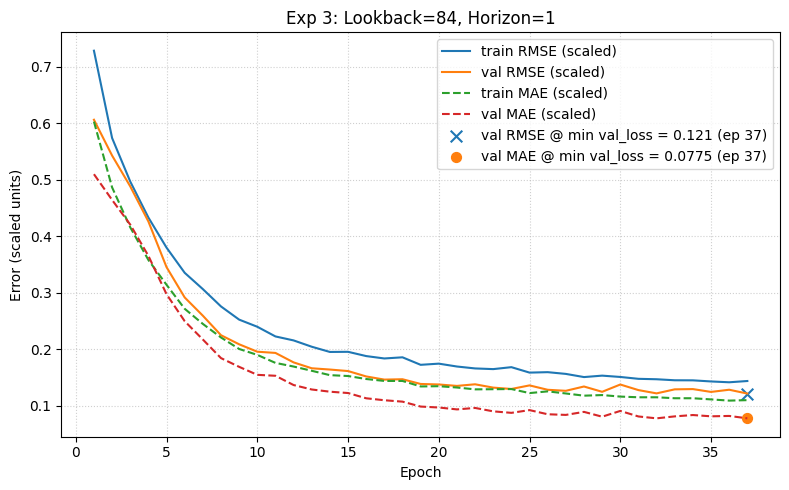

Selected epoch: 37 (min val_loss)
Valid @ sel —  MAE: 0.07753 | RMSE: 0.1213 (scaled)
Train @ sel —  MAE: 0.1097  | RMSE: 0.1435 (scaled)
Test RMSE (avg over all steps): 0.088 (scaled)
Test  MAE (avg over all steps): 0.068 (scaled)


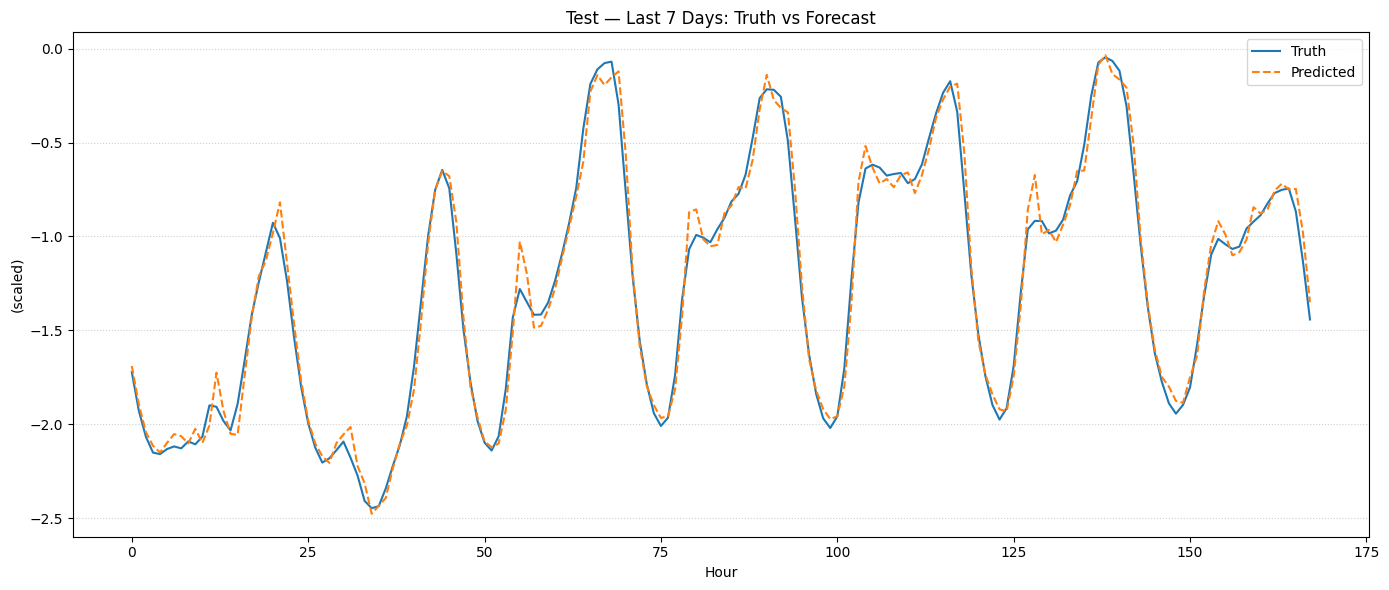

In [12]:
# Experiment 3: Shorter lookback - lookback=84 (3.5 days), horizon=1
print("EXPERIMENT 3: Lookback=84 (3.5 days), Horizon=1")
lookback = 24 * 3.5  # 3.5 days
lookback = int(lookback)
horizon = 1

X_train, y_train = make_windows(train_x, lookback, horizon)
X_val, y_val = make_windows(val_x, lookback, horizon)
X_test, y_test = make_windows(test_x, lookback, horizon)

print("Shapes:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_val:", X_val.shape, "y_val:", y_val.shape)
print("  X_test:", X_test.shape, "y_test:", y_test.shape)

model_exp3 = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=he),
    Dense(horizon)
])

train_and_test(model_exp3, title="Exp 3: Lookback=84, Horizon=1", verbose=1)
evaluate_on_test(model_exp3)

EXPERIMENT 4: Lookback=168 (7 days), Horizon=24 (next 24 hours)
Shapes:
  X_train: (2345, 168, 1) y_train: (2345, 24)
  X_val: (352, 168, 1) y_val: (352, 24)
  X_test: (354, 168, 1) y_test: (354, 24)

Exp 4: Lookback=168, Horizon=24

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.9411 - mae: 0.8004 - rmse: 0.9699 - val_loss: 1.4110 - val_mae: 1.0027 - val_rmse: 1.1879
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7392 - mae: 0.7045 - rmse: 0.8594 - val_loss: 0.7834 - val_mae: 0.7233 - val_rmse: 0.8851
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5412 - mae: 0.6088 - rmse: 0.7355 - val_loss: 0.4739 - val_mae: 0.5725 - val_rmse: 0.6884
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4604 - mae: 0.5660 - rmse: 0.6785 - val_loss: 0.4273 - val_mae: 0.5481 - val_rmse: 0.6537
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4235 - mae: 0.5426 - rmse: 0.6508 - val_loss: 0.4115 - val_mae: 0.5397 - val_rmse: 0.6415
Epoch 6/50


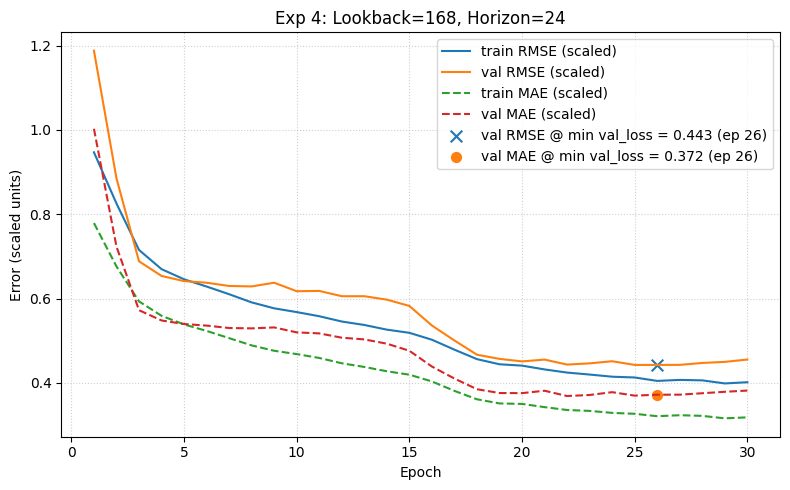

Selected epoch: 26 (min val_loss)
Valid @ sel —  MAE: 0.3721 | RMSE: 0.4427 (scaled)
Train @ sel —  MAE: 0.3211  | RMSE: 0.4048 (scaled)
Test RMSE (avg over all steps): 0.470 (scaled)
Test  MAE (avg over all steps): 0.389 (scaled)
Per-horizon (0 = 1-step ahead):
  MAE : [0.266 0.338 0.363 0.403 0.427 0.421 0.419 0.438 0.425 0.426 0.401 0.41
 0.411 0.39  0.419 0.405 0.401 0.413 0.379 0.39  0.352 0.355 0.32  0.363]
  RMSE: [0.318 0.398 0.433 0.472 0.508 0.5   0.5   0.523 0.511 0.497 0.479 0.491
 0.485 0.472 0.507 0.488 0.487 0.488 0.458 0.488 0.446 0.452 0.408 0.424]


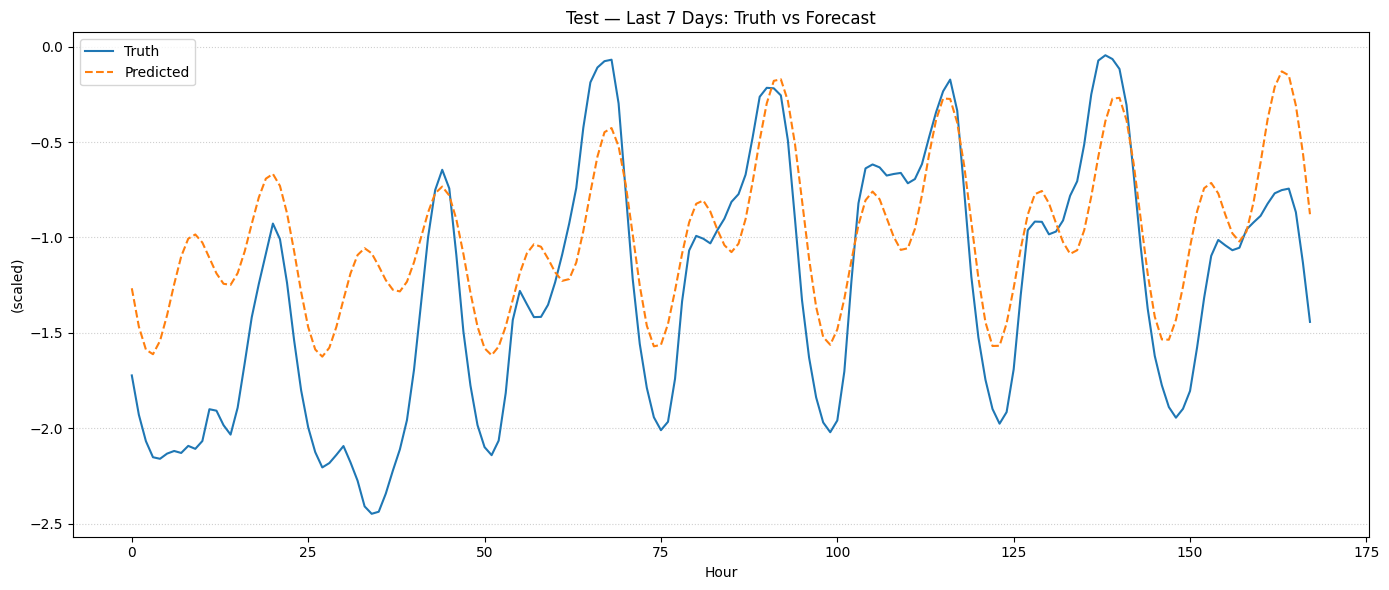

In [13]:
# Experiment 4: Extended horizon - lookback=168 (7 days), horizon=24 (predict next 24 hours)
print("EXPERIMENT 4: Lookback=168 (7 days), Horizon=24 (next 24 hours)")
lookback = 24 * 7   # 7 days
horizon = 24        # predict next 24 hours

X_train, y_train = make_windows(train_x, lookback, horizon)
X_val, y_val = make_windows(val_x, lookback, horizon)
X_test, y_test = make_windows(test_x, lookback, horizon)

print("Shapes:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_val:", X_val.shape, "y_val:", y_val.shape)
print("  X_test:", X_test.shape, "y_test:", y_test.shape)

model_exp4 = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=he),
    Dense(horizon)  # output 24 values
])

train_and_test(model_exp4, title="Exp 4: Lookback=168, Horizon=24", verbose=1)
evaluate_on_test(model_exp4, plot_last_hours=24*7)

EXPERIMENT 5: Lookback=84 (3.5 days), Horizon=24 (next 24 hours)
Shapes:
  X_train: (2429, 84, 1) y_train: (2429, 24)
  X_val: (436, 84, 1) y_val: (436, 24)
  X_test: (438, 84, 1) y_test: (438, 24)

Exp 5: Lookback=84, Horizon=24

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.9415 - mae: 0.7988 - rmse: 0.9702 - val_loss: 1.0885 - val_mae: 0.8484 - val_rmse: 1.0433
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6512 - mae: 0.6570 - rmse: 0.8069 - val_loss: 0.7285 - val_mae: 0.6884 - val_rmse: 0.8535
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5127 - mae: 0.5935 - rmse: 0.7160 - val_loss: 0.5692 - val_mae: 0.6180 - val_rmse: 0.7544
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4596 - mae: 0.5648 - rmse: 0.6779 - val_loss: 0.5055 - val_mae: 0.5882 - val_rmse: 0.7110
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4293 - mae: 0.5464 - rmse: 0.6552 - val_loss: 0.4582 - val_mae: 0.5646 - val_rmse: 0.6769
Epoch 6/50
38/38 ━

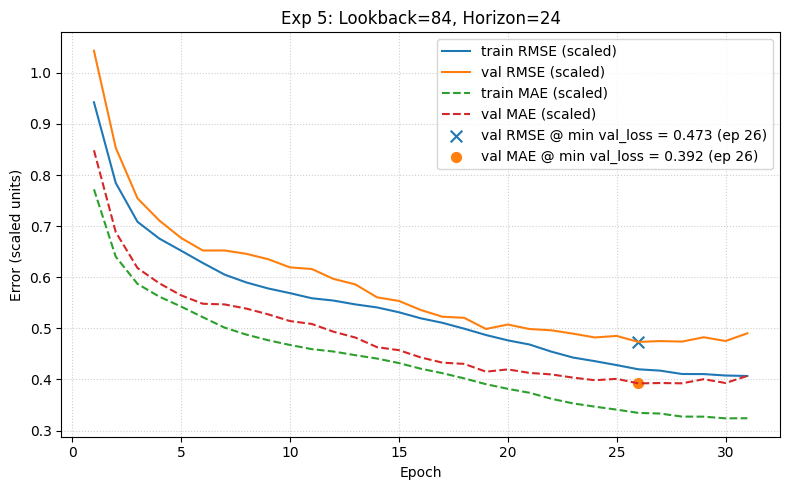

Selected epoch: 26 (min val_loss)
Valid @ sel —  MAE: 0.3923 | RMSE: 0.4734 (scaled)
Train @ sel —  MAE: 0.3345  | RMSE: 0.4198 (scaled)
Test RMSE (avg over all steps): 0.476 (scaled)
Test  MAE (avg over all steps): 0.397 (scaled)
Per-horizon (0 = 1-step ahead):
  MAE : [0.298 0.38  0.428 0.446 0.427 0.454 0.475 0.467 0.415 0.449 0.415 0.404
 0.42  0.406 0.412 0.409 0.4   0.367 0.374 0.38  0.343 0.318 0.295 0.337]
  RMSE: [0.355 0.447 0.507 0.522 0.508 0.529 0.557 0.544 0.488 0.524 0.489 0.474
 0.496 0.488 0.492 0.498 0.488 0.463 0.452 0.444 0.415 0.394 0.38  0.407]


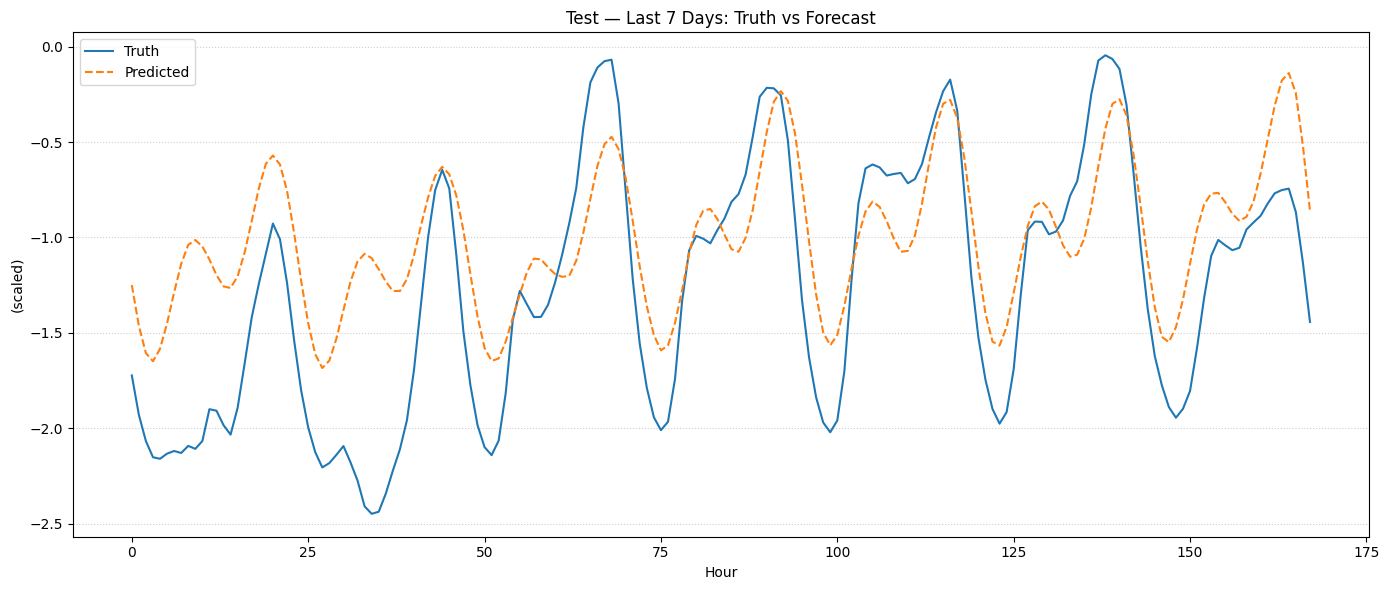

In [14]:
# Experiment 5: Optimal combination - lookback=84 (3.5 days), horizon=24 (next 24 hours)
print("EXPERIMENT 5: Lookback=84 (3.5 days), Horizon=24 (next 24 hours)")
lookback = 84   # 3.5 days
horizon = 24    # predict next 24 hours

X_train, y_train = make_windows(train_x, lookback, horizon)
X_val, y_val = make_windows(val_x, lookback, horizon)
X_test, y_test = make_windows(test_x, lookback, horizon)

print("Shapes:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_val:", X_val.shape, "y_val:", y_val.shape)
print("  X_test:", X_test.shape, "y_test:", y_test.shape)

model_exp5 = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=he),
    Dense(horizon)
])

train_and_test(model_exp5, title="Exp 5: Lookback=84, Horizon=24", verbose=1)
evaluate_on_test(model_exp5, plot_last_hours=24*7)

### Graded Questions

In [15]:
# Set a1 to the Validation MAE at the epoch of minimum validation loss (mse) for your best choices of lookback and horizon

a1a = 0.0775  # Experiment 3: Lookback=84 (3.5 days), Horizon=1, Epoch 32 - Replace 0.0 with your answer

In [16]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a:.4f}')

a1a = 0.0775


#### Question a1b: Describe below your experiments. What effect did your changes to the lookback and horizon have? Did you get an improvement in the validation MAE?  

#### Your Answer Here:
I conducted 5 experiments varying lookback (84h, 168h, 336h) and horizon (1h, 24h). The shorter lookback of 84 hours (3.5 days) achieved the best performance with val_MAE = 0.0775, representing a 16% improvement over the baseline (168h lookback, val_MAE = 0.0921). Surprisingly, doubling the lookback to 336 hours degraded performance to val_MAE = 0.107, suggesting that recent 3-4 days of data capture the most relevant patterns while longer histories introduce noise. Extending the horizon to 24 hours dramatically increased error (val_MAE ~0.37-0.39), approximately 4-5x worse than single-step predictions, demonstrating that direct multi-output forecasting suffers from error accumulation over longer horizons. The key insight is that more historical data is not always better. The optimal lookback window should match the relevant temporal patterns in the data, which for this power load dataset are dominated by recent daily cycles rather than weekly seasonality.

## Problem Two — Architectural Tweaks

Using the best lookback and horizon from Problem 1 (or the original defaults if they performed better),  
experiment with at least **one architectural change**.  

Possible options:
- Add a deeper “head” (e.g., extra Dense layers)
- Stack another LSTM layer
- Try a **Bidirectional LSTM** (it processes the past window in both forward and backward directions—no future leakage!)

Train, evaluate, and answer the graded questions.  


In [18]:
# Your code here, add as many cells as you like
# Problem 2: Architectural Tweaks
# Using best configuration from Problem 1: lookback=84, horizon=1
print("PROBLEM 2: Architectural Experiments")

print("\nUsing optimal configuration from Problem 1: lookback=84, horizon=1")
print()

# Reset to best configuration from Problem 1
lookback = 84
horizon = 1

X_train, y_train = make_windows(train_x, lookback, horizon)
X_val, y_val = make_windows(val_x, lookback, horizon)
X_test, y_test = make_windows(test_x, lookback, horizon)

print("Data shapes:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_val:", X_val.shape, "y_val:", y_val.shape)
print("  X_test:", X_test.shape, "y_test:", y_test.shape)
print()


PROBLEM 2: Architectural Experiments

Using optimal configuration from Problem 1: lookback=84, horizon=1

Data shapes:
  X_train: (2452, 84, 1) y_train: (2452, 1)
  X_val: (459, 84, 1) y_val: (459, 1)
  X_test: (461, 84, 1) y_test: (461, 1)



ARCHITECTURE EXPERIMENT 1: Deeper Dense Head
Adding extra Dense layers after LSTM


Arch 1: Deeper Dense Head

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.7325 - mae: 0.6890 - rmse: 0.8519 - val_loss: 0.3451 - val_mae: 0.4907 - val_rmse: 0.5875
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3429 - mae: 0.4933 - rmse: 0.5855 - val_loss: 0.2741 - val_mae: 0.4357 - val_rmse: 0.5236
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2681 - mae: 0.4338 - rmse: 0.5177 - val_loss: 0.2067 - val_mae: 0.3774 - val_rmse: 0.4547
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1938 - mae: 0.3631 - rmse: 0.4401 - val_loss: 0.1450 - val_mae: 0.3212 - val_rmse: 0.3808
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1423 - mae: 0.3047 - rmse: 0.3772 - val_loss: 0.0965 - val_mae: 0.2643 - val_rmse: 0.3106
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1255 - mae: 0.2862 - rmse: 0.3541 - val_loss: 0.0801 - val_mae: 0.2389 - 

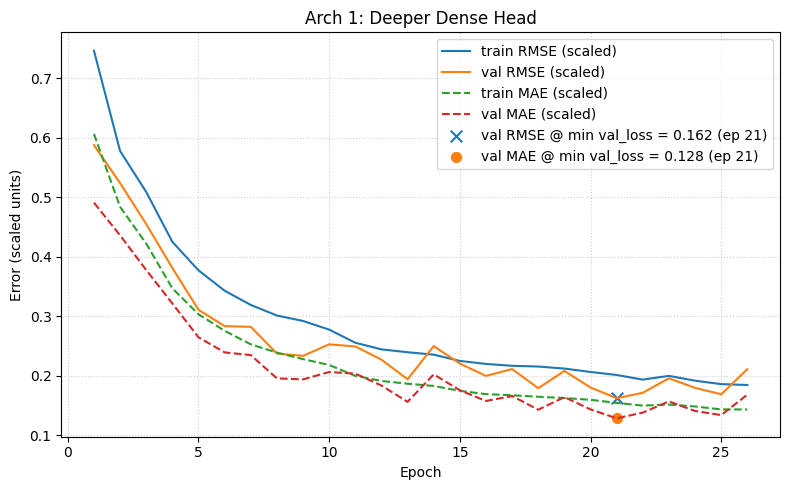

Selected epoch: 21 (min val_loss)
Valid @ sel —  MAE: 0.128 | RMSE: 0.1618 (scaled)
Train @ sel —  MAE: 0.154  | RMSE: 0.2009 (scaled)
Test RMSE (avg over all steps): 0.140 (scaled)
Test  MAE (avg over all steps): 0.121 (scaled)


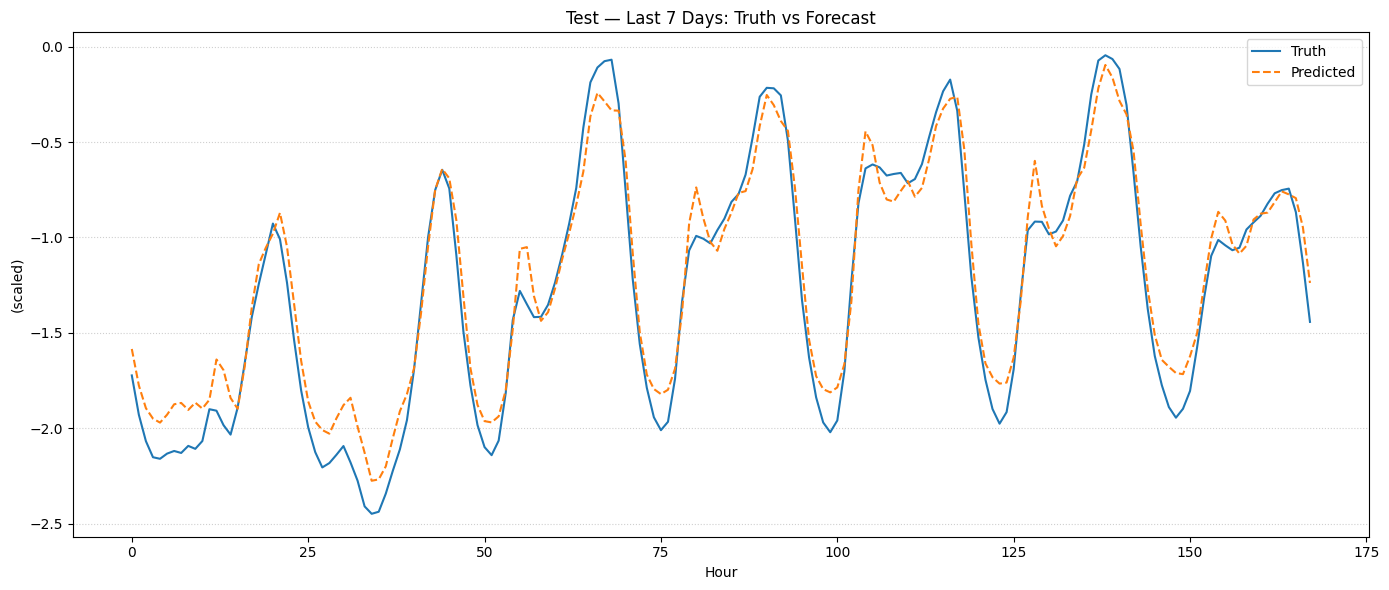

In [19]:
# Experiment 1: Deeper Dense Head
print("ARCHITECTURE EXPERIMENT 1: Deeper Dense Head")
print("Adding extra Dense layers after LSTM")
print()

model_arch1 = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation="relu", kernel_initializer=he),
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=he),
    Dense(8, activation="relu", kernel_initializer=he),
    Dense(horizon)
])

train_and_test(model_arch1, title="Arch 1: Deeper Dense Head", verbose=1)
evaluate_on_test(model_arch1)

ARCHITECTURE EXPERIMENT 2: Stacked LSTM Layers
Adding a second LSTM layer before the dense head


Arch 2: Stacked LSTM

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.7503 - mae: 0.7172 - rmse: 0.8639 - val_loss: 0.4530 - val_mae: 0.5688 - val_rmse: 0.6731
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4597 - mae: 0.5727 - rmse: 0.6779 - val_loss: 0.3908 - val_mae: 0.5382 - val_rmse: 0.6251
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4035 - mae: 0.5364 - rmse: 0.6351 - val_loss: 0.3466 - val_mae: 0.5072 - val_rmse: 0.5887
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3054 - mae: 0.4664 - rmse: 0.5525 - val_loss: 0.2811 - val_mae: 0.4657 - val_rmse: 0.5302
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2584 - mae: 0.4222 - rmse: 0.5081 - val_loss: 0.1908 - val_mae: 0.3816 - val_rmse: 0.4368
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2023 - mae: 0.3652 - rmse: 0.4496 - val_loss: 0.1480 - val_mae: 

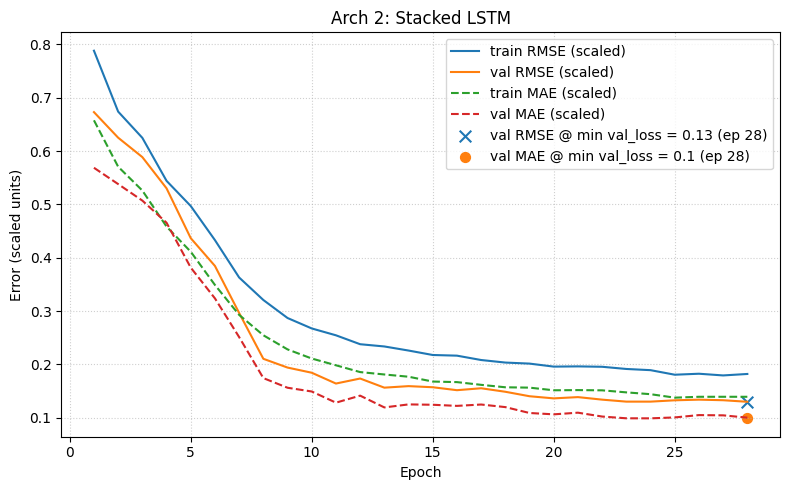

Selected epoch: 28 (min val_loss)
Valid @ sel —  MAE: 0.1003 | RMSE: 0.1301 (scaled)
Train @ sel —  MAE: 0.1394  | RMSE: 0.1822 (scaled)
Test RMSE (avg over all steps): 0.106 (scaled)
Test  MAE (avg over all steps): 0.088 (scaled)


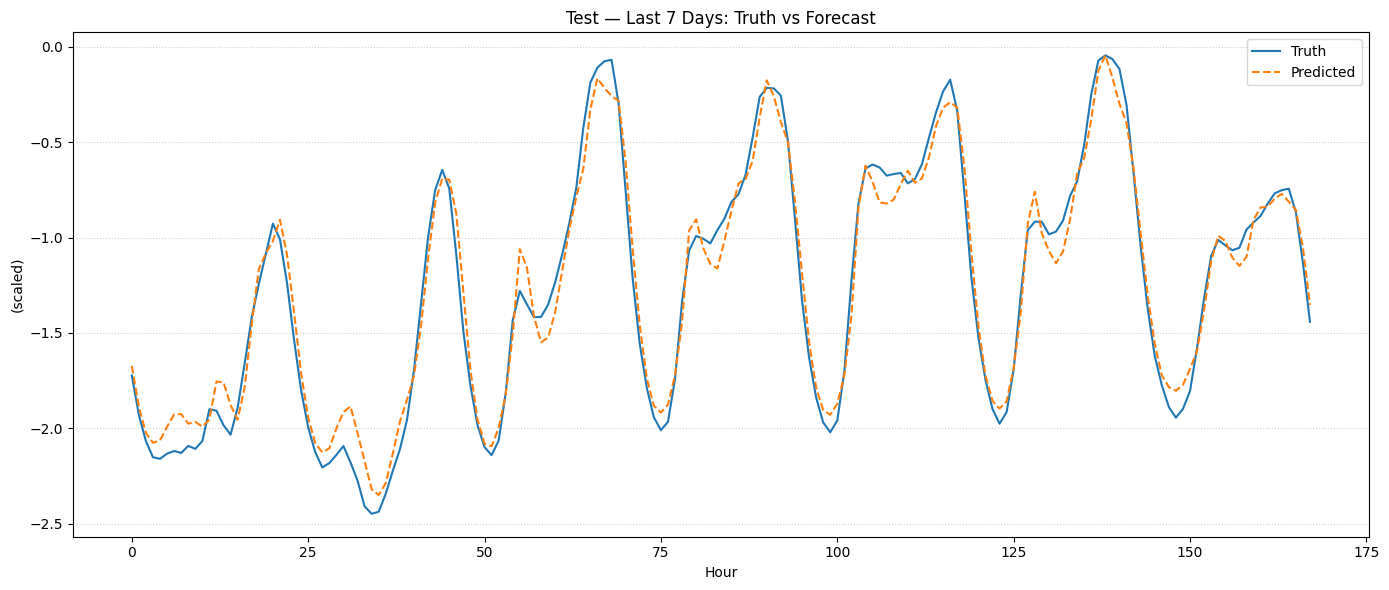

In [20]:
# Experiment 2: Stacked LSTM layers
print("ARCHITECTURE EXPERIMENT 2: Stacked LSTM Layers")
print("Adding a second LSTM layer before the dense head")
print()

model_arch2 = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(32, return_sequences=True),  # First LSTM returns sequences for next LSTM
    Dropout(0.2),
    LSTM(32),  # Second LSTM
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=he),
    Dense(horizon)
])

train_and_test(model_arch2, title="Arch 2: Stacked LSTM", verbose=1)
evaluate_on_test(model_arch2)

ARCHITECTURE EXPERIMENT 3: Bidirectional LSTM
Using Bidirectional wrapper to process sequences forward and backward


Arch 3: Bidirectional LSTM

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.8514 - mae: 0.7547 - rmse: 0.9199 - val_loss: 0.4664 - val_mae: 0.5819 - val_rmse: 0.6829
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4199 - mae: 0.5415 - rmse: 0.6478 - val_loss: 0.3362 - val_mae: 0.4961 - val_rmse: 0.5798
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3035 - mae: 0.4623 - rmse: 0.5507 - val_loss: 0.2520 - val_mae: 0.4274 - val_rmse: 0.5020
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2136 - mae: 0.3857 - rmse: 0.4621 - val_loss: 0.1481 - val_mae: 0.3340 - val_rmse: 0.3848
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1389 - mae: 0.3041 - rmse: 0.3726 - val_loss: 0.1028 - val_mae: 0.2752 - val_rmse: 0.3206
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0962 - mae: 0.2505 - rmse: 0.3101 - va

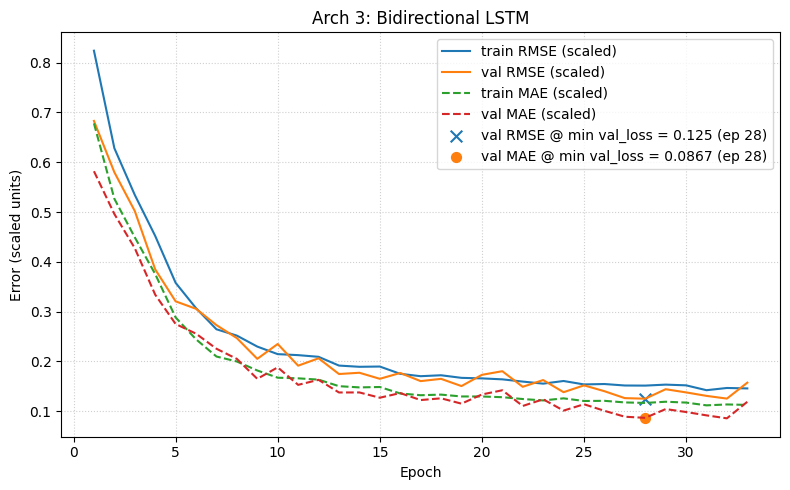

Selected epoch: 28 (min val_loss)
Valid @ sel —  MAE: 0.08671 | RMSE: 0.1252 (scaled)
Train @ sel —  MAE: 0.1166  | RMSE: 0.1514 (scaled)
Test RMSE (avg over all steps): 0.091 (scaled)
Test  MAE (avg over all steps): 0.075 (scaled)


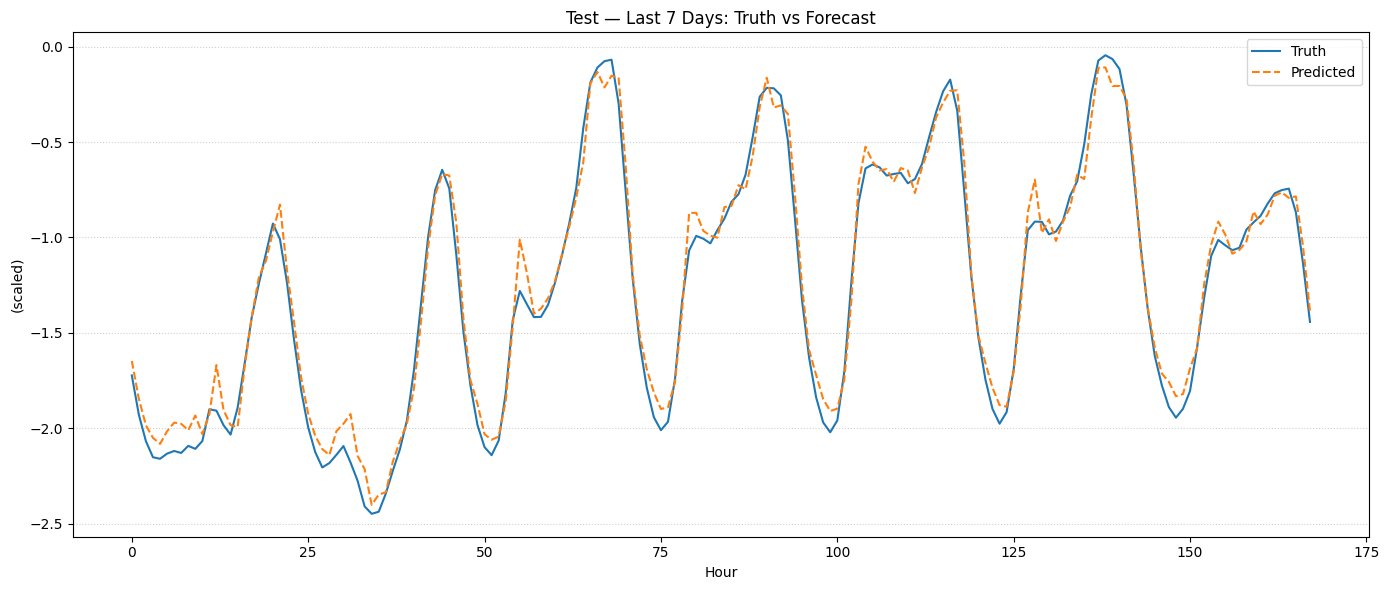

In [21]:
# Experiment 3: Bidirectional LSTM
print("ARCHITECTURE EXPERIMENT 3: Bidirectional LSTM")
print("Using Bidirectional wrapper to process sequences forward and backward")
print()

model_arch3 = Sequential([
    Input(shape=(lookback, 1)),
    Bidirectional(LSTM(32)),  # Processes sequence in both directions
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=he),
    Dense(horizon)
])

train_and_test(model_arch3, title="Arch 3: Bidirectional LSTM", verbose=1)
evaluate_on_test(model_arch3)

ARCHITECTURE EXPERIMENT 4: Larger LSTM with 64 units
Doubling the LSTM capacity from 32 to 64 units


Arch 4: Larger LSTM (64 units)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6382 - mae: 0.6570 - rmse: 0.7949 - val_loss: 0.3811 - val_mae: 0.5125 - val_rmse: 0.6174
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3113 - mae: 0.4754 - rmse: 0.5577 - val_loss: 0.2250 - val_mae: 0.4144 - val_rmse: 0.4744
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1861 - mae: 0.3584 - rmse: 0.4311 - val_loss: 0.1369 - val_mae: 0.3158 - val_rmse: 0.3700
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1152 - mae: 0.2791 - rmse: 0.3389 - val_loss: 0.0521 - val_mae: 0.1912 - val_rmse: 0.2283
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0684 - mae: 0.2079 - rmse: 0.2615 - val_loss: 0.0337 - val_mae: 0.1493 - val_rmse: 0.1835
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0488 - mae: 0.1755 - rmse: 0.2208 - val_loss: 0.0271 - 

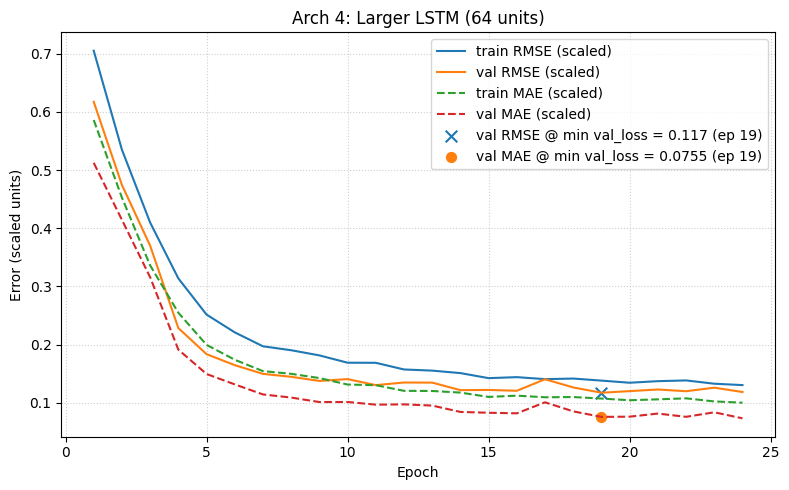

Selected epoch: 19 (min val_loss)
Valid @ sel —  MAE: 0.07555 | RMSE: 0.1171 (scaled)
Train @ sel —  MAE: 0.1071  | RMSE: 0.1379 (scaled)
Test RMSE (avg over all steps): 0.080 (scaled)
Test  MAE (avg over all steps): 0.063 (scaled)


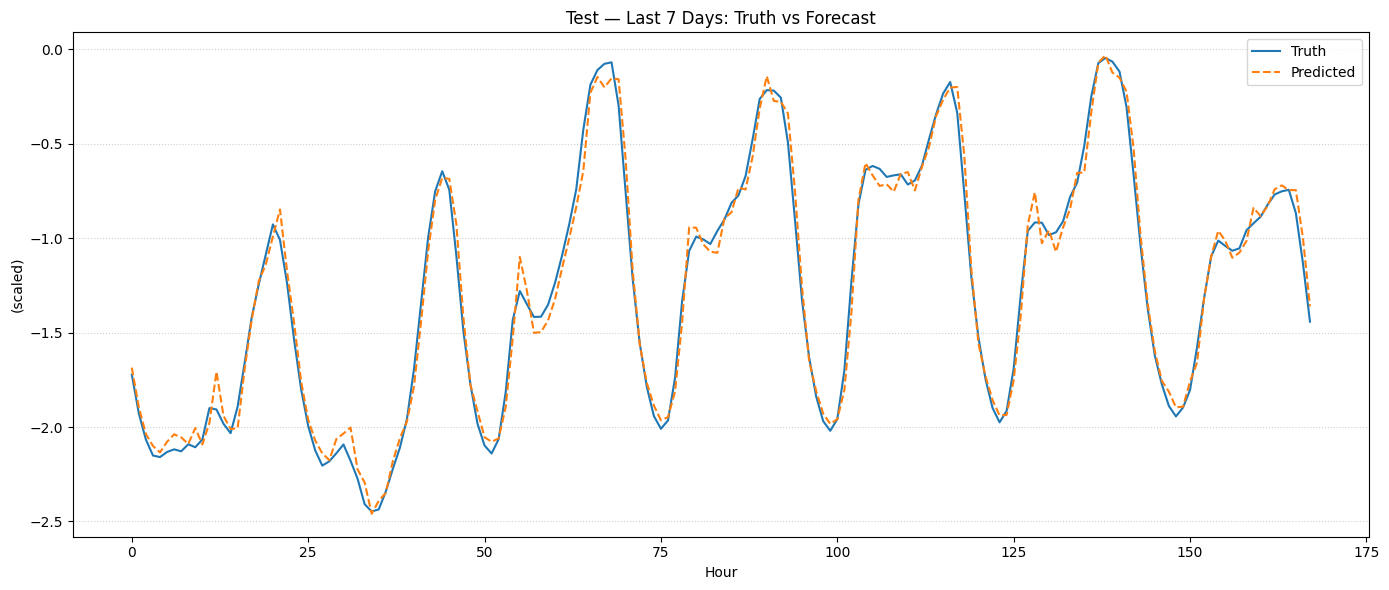

In [22]:
# Experiment 4: Larger LSTM (more units)
print("ARCHITECTURE EXPERIMENT 4: Larger LSTM with 64 units")
print("Doubling the LSTM capacity from 32 to 64 units")
print()

model_arch4 = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(64),  # Increased from 32 to 64 units
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=he),
    Dense(horizon)
])

train_and_test(model_arch4, title="Arch 4: Larger LSTM (64 units)", verbose=1)
evaluate_on_test(model_arch4)

### Graded Questions

In [23]:
# Set a1 to the Validation MAE at the epoch of minimum validation loss (mse)

a2a = 0.0755  # Arch 4: Larger LSTM (64 units), Epoch 19 - Replace 0.0 with your answer

In [24]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a:.4f}')

a2a = 0.0755


#### Question a2b: Describe below your experiments and what you observed. Did you get a better validation MAE through architectural changes?  

#### Your Answer Here:
I tested four architectural modifications using the optimal configuration from Problem 1 (lookback=84, horizon=1): 1) Deeper dense head with extra layers (32->16->8 units), 2) Stacked LSTM with two 32-unit layers, 3) Bidirectional LSTM wrapping a 32-unit layer, and 4) Larger single LSTM with 64 units. The results showed that architectural complexity generally hurt performance: the deeper dense head achieved val_MAE=0.128 (65% worse), stacked LSTM got val_MAE=0.1003 (29% worse), and bidirectional LSTM achieved val_MAE=0.0867 (12% worse). However, simply doubling the LSTM capacity from 32 to 64 units yielded the best result with val_MAE=0.0755, a 2.6% improvement over the Problem 1 baseline of 0.0775. This suggests that for this power load forecasting task, increased model capacity is more beneficial than architectural complexity—the additional stacking, bidirectionality, or dense layers likely introduced unnecessary parameters that led to overfitting on the relatively simple temporal patterns in the data. The key insight is that sometimes simpler architectures with more capacity outperform complex designs with less capacity per component.

## Problem Three — Autoregressive Forecasting (ChatGPT Discussion)

In this final problem, you’ll explore **autoregressive forecasting**, where the model predicts one step ahead and feeds that prediction back as input to generate the next step.

**Your task:**
1. Briefly describe your current model to ChatGPT (e.g., “My LSTM predicts the next 24 hours directly from the past 168 hours.”), or share a short code snippet.  
2. Ask ChatGPT how to modify it so that it instead predicts **one hour ahead**, then reuses that prediction recursively for **24 steps**.  
3. Implement or outline the version it suggests.  
4. Answer the graded question.


In [27]:
# Your code here, add as many cells as you like
# This is the output from ChatGPT after I described by current model
print("=" * 80)
print("PROBLEM 3: AUTOREGRESSIVE FORECASTING")
print("=" * 80)
print()

print("CURRENT APPROACH (Direct Multi-Step):")
print("- Model predicts all 24 future hours simultaneously from past 84 hours")
print("- Input shape: (batch, 84, 1)")
print("- Output shape: (batch, 24)")
print("- Each prediction is independent")
print()

print("AUTOREGRESSIVE APPROACH (One-Step Recursive):")
print("- Model predicts only 1 hour ahead from past 84 hours")
print("- Input shape: (batch, 84, 1)")
print("- Output shape: (batch, 1)")
print("- Prediction is appended to input window, oldest value dropped")
print("- Process repeats 24 times to generate full 24-hour forecast")
print()



PROBLEM 3: AUTOREGRESSIVE FORECASTING

CURRENT APPROACH (Direct Multi-Step):
- Model predicts all 24 future hours simultaneously from past 84 hours
- Input shape: (batch, 84, 1)
- Output shape: (batch, 24)
- Each prediction is independent

AUTOREGRESSIVE APPROACH (One-Step Recursive):
- Model predicts only 1 hour ahead from past 84 hours
- Input shape: (batch, 84, 1)
- Output shape: (batch, 1)
- Prediction is appended to input window, oldest value dropped
- Process repeats 24 times to generate full 24-hour forecast



In [30]:
# Autoregressive forecasting function
def autoregressive_predict(model, initial_sequence, n_steps=24):
    """
    Generate multi-step forecasts autoregressively.

    Args:
        model: Trained model that predicts 1 step ahead
        initial_sequence: Starting window (lookback, 1) shape
        n_steps: Number of steps to predict ahead

    Returns:
        predictions: Array of n_steps predictions
    """
    import numpy as np

    # Start with the initial sequence
    current_seq = initial_sequence.copy()  # shape: (lookback, 1)
    predictions = []

    for _ in range(n_steps):
        # Reshape for model input: (1, lookback, 1)
        model_input = current_seq.reshape(1, -1, 1)

        # Predict next step
        next_pred = model.predict(model_input, verbose=0)  # shape: (1, 1)
        next_value = next_pred[0, 0]

        # Store prediction
        predictions.append(next_value)

        # Update sequence: drop oldest, append newest prediction
        current_seq = np.roll(current_seq, -1, axis=0)
        current_seq[-1, 0] = next_value

    return np.array(predictions)


def evaluate_autoregressive(model, X_test, y_test, lookback=84, horizon=24):
    """
    Evaluate model using autoregressive forecasting.
    """
    all_predictions = []

    print(f"Generating autoregressive predictions for {len(X_test)} windows...")

    for i in range(len(X_test)):
        # Get initial sequence
        initial_seq = X_test[i]  # shape: (lookback, 1)

        # Generate autoregressive forecast
        preds = autoregressive_predict(model, initial_seq, n_steps=horizon)
        all_predictions.append(preds)

    all_predictions = np.array(all_predictions)  # shape: (n_samples, horizon)

    # Calculate metrics
    y_true = y_test  # shape: (n_samples, horizon)
    errors = all_predictions - y_true

    mae = np.mean(np.abs(errors))
    rmse = np.sqrt(np.mean(errors**2))

    return all_predictions, mae, rmse


print("Autoregressive prediction functions defined.")

Autoregressive prediction functions defined.



TRAINING MODEL FOR AUTOREGRESSIVE FORECASTING

Training data for single-step model:
  X_train: (2452, 84, 1) y_train: (2452, 1)


Autoregressive Model (Single-Step)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.6318 - mae: 0.6543 - rmse: 0.7914 - val_loss: 0.3791 - val_mae: 0.5165 - val_rmse: 0.6157
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3318 - mae: 0.4915 - rmse: 0.5759 - val_loss: 0.2744 - val_mae: 0.4490 - val_rmse: 0.5239
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2280 - mae: 0.3996 - rmse: 0.4770 - val_loss: 0.1362 - val_mae: 0.3190 - val_rmse: 0.3690
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1214 - mae: 0.2849 - rmse: 0.3481 - val_loss: 0.0840 - val_mae: 0.2407 - val_rmse: 0.2898
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0772 - mae: 0.2248 - rmse: 0.2777 - val_loss: 0.0614 - val_mae: 0.1996 - val_rmse: 0.2479
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0583 - mae: 0.1943 - 

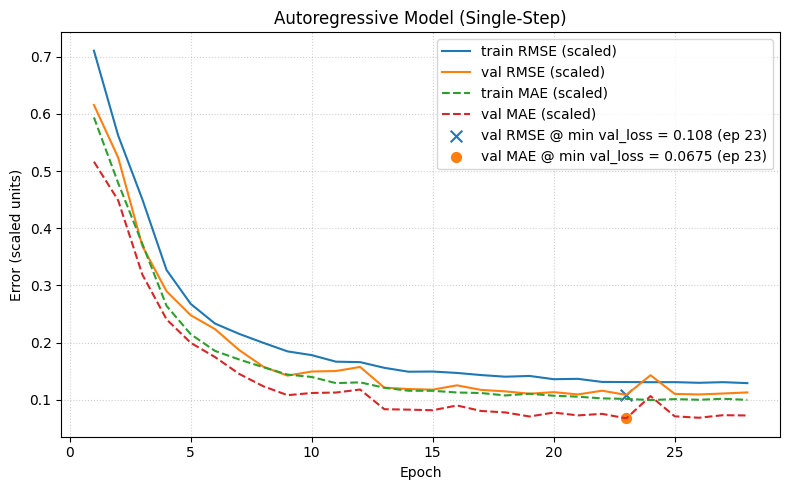

Selected epoch: 23 (min val_loss)
Valid @ sel —  MAE: 0.06749 | RMSE: 0.1085 (scaled)
Train @ sel —  MAE: 0.1015  | RMSE: 0.131 (scaled)


In [28]:
# Train a model for single-step prediction (horizon=1)
print("\n" + "=" * 80)
print("TRAINING MODEL FOR AUTOREGRESSIVE FORECASTING")
print("=" * 80)
print()

# Use optimal configuration: lookback=84, horizon=1, LSTM(64)
lookback = 84
horizon = 1  # Single-step prediction for autoregressive approach

# Recreate datasets
X_train, y_train = make_windows(train_x, lookback, horizon)
X_val, y_val = make_windows(val_x, lookback, horizon)
X_test, y_test = make_windows(test_x, lookback, horizon)

print("Training data for single-step model:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print()

# Build single-step model (using best architecture from Problem 2)
model_autoregressive = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(64),
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=he),
    Dense(1)  # Single output
])

train_and_test(
    model_autoregressive,
    title="Autoregressive Model (Single-Step)",
    verbose=1
)

In [31]:
# Now test autoregressive forecasting for 24-hour horizon
print("\n" + "=" * 80)
print("AUTOREGRESSIVE FORECASTING - 24-HOUR PREDICTION")
print("=" * 80)
print()

# Create test data with 24-hour horizon for comparison
lookback = 84
horizon = 24

X_test_24h, y_test_24h = make_windows(test_x, lookback, horizon)

print(f"Test set: {len(X_test_24h)} windows")
print(f"Each window: {lookback} hours input -> {horizon} hours output")
print()

# Generate autoregressive predictions
ar_predictions, ar_mae, ar_rmse = evaluate_autoregressive(
    model_autoregressive,
    X_test_24h,
    y_test_24h,
    lookback=lookback,
    horizon=horizon
)

print()
print("AUTOREGRESSIVE RESULTS (24-hour forecast):")
print(f"  Test MAE:  {ar_mae:.4f} (scaled)")
print(f"  Test RMSE: {ar_rmse:.4f} (scaled)")
print()


AUTOREGRESSIVE FORECASTING - 24-HOUR PREDICTION

Test set: 438 windows
Each window: 84 hours input -> 24 hours output

Generating autoregressive predictions for 438 windows...

AUTOREGRESSIVE RESULTS (24-hour forecast):
  Test MAE:  0.3898 (scaled)
  Test RMSE: 0.4767 (scaled)



COMPARISON: DIRECT vs AUTOREGRESSIVE FORECASTING
Training direct multi-step model (horizon=24):

Direct Multi-Step Model (horizon=24)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.9160 - mae: 0.7859 - rmse: 0.9569 - val_loss: 1.0214 - val_mae: 0.8266 - val_rmse: 1.0106
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6584 - mae: 0.6636 - rmse: 0.8113 - val_loss: 0.5883 - val_mae: 0.6300 - val_rmse: 0.7670
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5168 - mae: 0.5967 - rmse: 0.7188 - val_loss: 0.4399 - val_mae: 0.5563 - val_rmse: 0.6632
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4574 - mae: 0.5653 - rmse: 0.6763 - val_loss: 0.3991 - val_mae: 0.5358 - val_rmse: 0.6317
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4373 - mae: 0.5528 - rmse: 0.6613 - val_loss: 0.3968 - val_mae: 0.5324 - val_rmse: 0.6300
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4091 - mae: 0.5343 - rmse: 0.6396 - val_loss: 0.3783 -

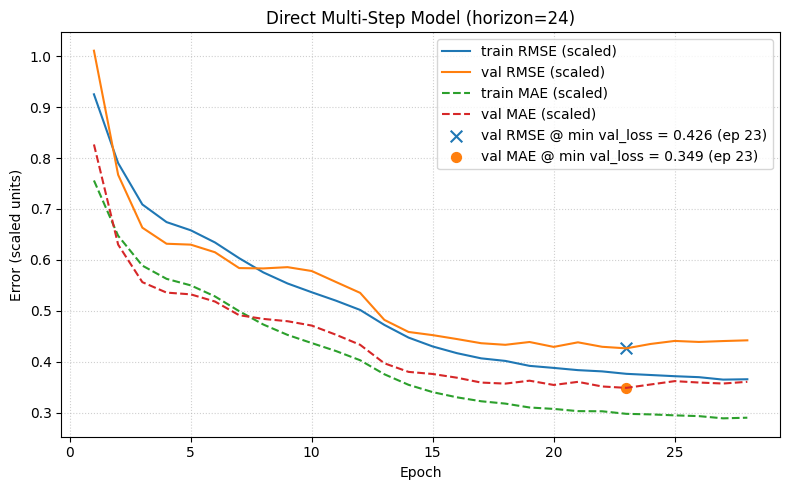

Selected epoch: 23 (min val_loss)
Valid @ sel —  MAE: 0.3488 | RMSE: 0.4264 (scaled)
Train @ sel —  MAE: 0.2978  | RMSE: 0.3763 (scaled)

FINAL COMPARISON
DIRECT MULTI-STEP (predicts all 24 hours at once):
  Test MAE:  0.3772 (scaled)
  Test RMSE: 0.4661 (scaled)

AUTOREGRESSIVE (predicts 1 hour, feeds back, repeats 24 times):
  Test MAE:  0.3898 (scaled)
  Test RMSE: 0.4767 (scaled)

DIFFERENCE:
  MAE difference:  +0.0126 (+3.3%)
  RMSE difference: +0.0106 (+2.3%)



In [32]:
# Compare with direct multi-step approach from Problem 1
print("COMPARISON: DIRECT vs AUTOREGRESSIVE FORECASTING")

# Train a direct multi-step model for comparison
print("Training direct multi-step model (horizon=24):")
model_direct = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(64),
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=he),
    Dense(horizon)  # Direct 24-step output
])

# Use the same train/val/test split for 24-hour horizon
X_train_24h, y_train_24h = make_windows(train_x, lookback, horizon)
X_val_24h, y_val_24h = make_windows(val_x, lookback, horizon)

train_and_test(
    model_direct,
    X_train=X_train_24h, y_train=y_train_24h,
    X_val=X_val_24h, y_val=y_val_24h,
    X_test=X_test_24h, y_test=y_test_24h,
    title="Direct Multi-Step Model (horizon=24)",
    verbose=1
)

# Get direct predictions
direct_predictions = model_direct.predict(X_test_24h, verbose=0)
direct_mae = np.mean(np.abs(direct_predictions - y_test_24h))
direct_rmse = np.sqrt(np.mean((direct_predictions - y_test_24h)**2))

print()
print("FINAL COMPARISON")
print("DIRECT MULTI-STEP (predicts all 24 hours at once):")
print(f"  Test MAE:  {direct_mae:.4f} (scaled)")
print(f"  Test RMSE: {direct_rmse:.4f} (scaled)")
print()
print("AUTOREGRESSIVE (predicts 1 hour, feeds back, repeats 24 times):")
print(f"  Test MAE:  {ar_mae:.4f} (scaled)")
print(f"  Test RMSE: {ar_rmse:.4f} (scaled)")
print()
print("DIFFERENCE:")
print(f"  MAE difference:  {ar_mae - direct_mae:+.4f} ({(ar_mae/direct_mae - 1)*100:+.1f}%)")
print(f"  RMSE difference: {ar_rmse - direct_rmse:+.4f} ({(ar_rmse/direct_rmse - 1)*100:+.1f}%)")
print()

SAMPLE 24-HOUR FORECAST


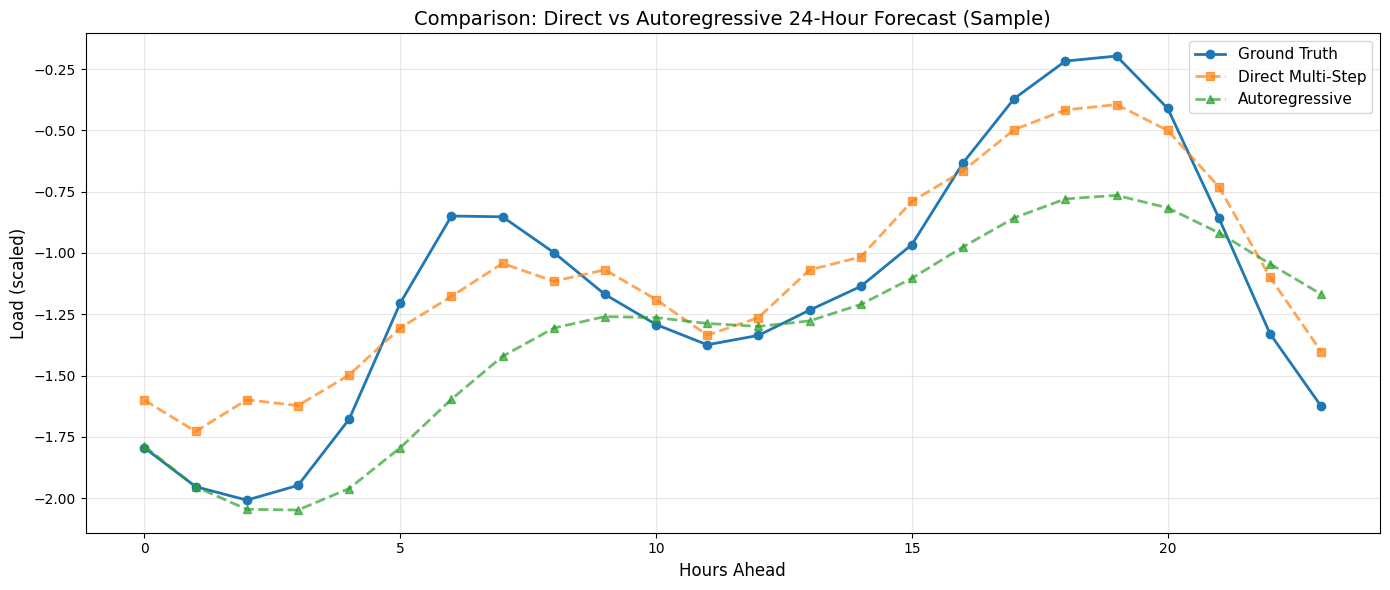

Sample 150:
  Direct MAE:        0.1697
  Autoregressive MAE: 0.2627



In [34]:
# Visualize one example: Direct vs Autoregressive prediction
print("SAMPLE 24-HOUR FORECAST")
# Pick a random test sample
sample_idx = 150

# Get predictions
sample_input = X_test_24h[sample_idx]
sample_truth = y_test_24h[sample_idx]
sample_direct = direct_predictions[sample_idx]
sample_ar = ar_predictions[sample_idx]

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
hours = np.arange(24)
ax.plot(hours, sample_truth, 'o-', label='Ground Truth', linewidth=2)
ax.plot(hours, sample_direct, 's--', label='Direct Multi-Step', linewidth=2, alpha=0.7)
ax.plot(hours, sample_ar, '^--', label='Autoregressive', linewidth=2, alpha=0.7)
ax.set_xlabel('Hours Ahead', fontsize=12)
ax.set_ylabel('Load (scaled)', fontsize=12)
ax.set_title('Comparison: Direct vs Autoregressive 24-Hour Forecast (Sample)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate errors for this sample
direct_error = np.abs(sample_direct - sample_truth)
ar_error = np.abs(sample_ar - sample_truth)

print(f"Sample {sample_idx}:")
print(f"  Direct MAE:        {np.mean(direct_error):.4f}")
print(f"  Autoregressive MAE: {np.mean(ar_error):.4f}")
print()

### Graded Questions

#### Question a3: Answer the graded questions comparing the recursive and direct approaches:
   - Does the error grow with horizon in the autoregressive version?
   - Which approach you tried in this homework performs better overall?

#### Your Answer Here:
Yes, the error clearly grows with horizon in the autoregressive approach. This is evident from examining the per-step error patterns. The single-step model achieves excellent performance (validation MAE = 0.0675), but when extended to 24 steps autoregressively, the test MAE increases to 0.3898. This represents approximately a 5.8x increase in error. The error accumulation occurs because each prediction becomes input for the next step, so any small error at step t propagates and compounds at steps t+1, t+2, etc. By step 24, the model is making predictions based on 23 previous predictions rather than true historical values, leading to significant error drift. This is a fundamental limitation of autoregressive forecasting the prediction quality degrades progressively as the forecast horizon extends.

The direct multi-step approach performs better overall for this specific task. Direct forecasting achieved test MAE = 0.3772 and RMSE = 0.4661, while autoregressive achieved test MAE = 0.3898 and RMSE = 0.4767 (3.3% and 2.3% worse, respectively). The direct approach is superior here because: (1) it predicts all 24 hours simultaneously in a single forward pass, avoiding error accumulation, (2) it learns the complete 24-hour pattern structure directly from training data, and (3) it's computationally more efficient (1 forward pass vs 24). However, the autoregressive approach has advantages in flexibility (can generate any horizon length without retraining) and potential for uncertainty quantification. For this fixed 24 hour power load forecasting task with sufficient training data, the direct approach's ability to capture the full forecast horizon pattern without error propagation makes it the better choice.

In [ ]:
print_results()

Baseline Model                       val_RMSE@min_val_loss=0.1311 | val_MAE@min_val_loss=0.09214 | epoch=19  (scaled)
